In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.inspection import permutation_importance
import shap
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

class PascalFeatureGenerator:
    """
    Generate optimized Pascal's Triangle-based features for breast cancer dataset
    """
    
    def __init__(self, max_row=10):
        self.max_row = max_row
        self.pascal_triangle = self._generate_pascal_triangle()
    
    def _generate_pascal_triangle(self):
        """Generate Pascal's triangle up to max_row"""
        triangle = [[1]]
        for i in range(1, self.max_row):
            row = [1]
            for j in range(1, i):
                row.append(triangle[i-1][j-1] + triangle[i-1][j])
            row.append(1)
            triangle.append(row)
        return triangle
    
    def get_binomial_coefficient(self, n, k):
        """Calculate binomial coefficient C(n,k)"""
        if k > n or k < 0:
            return 0
        return self.pascal_triangle[n][k]
    
    def generate_pascal_features(self, X, feature_importance=None):
        """
        Generate dataset-specific Pascal's Triangle-based features
        
        Features generated:
        1. Quantile-mapped binomial coefficients (weighted by feature importance)
        2. Recursive interaction terms
        3. Normalized mod-2 patterns
        4. Combinatorial interaction terms
        """
        
        X_scaled = StandardScaler().fit_transform(X)
        n_samples, n_features = X_scaled.shape
        pascal_features = []
        
        # Compute quantiles for feature mapping
        quantiles = np.quantile(X_scaled, np.linspace(0, 1, self.max_row), axis=0)
        
        # Use feature importance if provided
        if feature_importance is None:
            feature_importance = np.ones(n_features)
        
        for i in range(n_samples):
            sample_features = []
            
            # 1. Quantile-mapped binomial coefficients
            for j in range(min(n_features, 3)):
                val = X_scaled[i, j]
                n_val = np.searchsorted(quantiles[:, j], val, side='right')
                n_val = min(n_val, self.max_row - 1)
                k_val = min(j + 1, n_val)
                binom_coeff = self.get_binomial_coefficient(n_val, k_val)
                sample_features.append(binom_coeff * feature_importance[j] / (n_val + 1))
            
            # 2. Recursive interaction terms
            for j in range(min(n_features-1, 2)):
                val1, val2 = X_scaled[i, j], X_scaled[i, j+1]
                n1 = np.searchsorted(quantiles[:, j], val1, side='right')
                n2 = np.searchsorted(quantiles[:, j+1], val2, side='right')
                n1, n2 = min(n1, self.max_row - 1), min(n2, self.max_row - 1)
                k = min(j + 1, min(n1, n2))
                coeff1 = self.get_binomial_coefficient(n1, k)
                coeff2 = self.get_binomial_coefficient(n2, k)
                interaction = (coeff1 * coeff2) * (feature_importance[j] + feature_importance[j+1]) / (n1 + n2 + 1)
                sample_features.append(interaction)
            
            # 3. Normalized mod-2 patterns
            for j in range(min(n_features, 2)):
                n_val = np.searchsorted(quantiles[:, j], X_scaled[i, j], side='right')
                n_val = min(n_val, self.max_row - 1)
                binary_pattern = [val % 2 for val in self.pascal_triangle[n_val]]
                binary_value = sum(bit * (2 ** idx) for idx, bit in enumerate(binary_pattern[:3]))
                sample_features.append(binary_value * feature_importance[j] / (2 ** 3))
            
            # 4. Combinatorial interaction terms
            for j in range(min(n_features-2, 1)):
                val1, val2, val3 = X_scaled[i, j], X_scaled[i, j+1], X_scaled[i, j+2]
                n1 = np.searchsorted(quantiles[:, j], val1, side='right')
                n1 = min(n1, self.max_row - 1)
                k = min(j + 1, n1)
                binom_coeff = self.get_binomial_coefficient(n1, k)
                comb_term = binom_coeff * (val1 * val2 * val3) * feature_importance[j]
                sample_features.append(comb_term / (n1 + 1))
            
            pascal_features.append(sample_features)
        
        return np.array(pascal_features)

def evaluate_classifier(clf, X_train, X_test, y_train, y_test, name):
    """Evaluate classifier and return metrics"""
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cv_scores = cross_val_score(clf.best_estimator_ if hasattr(clf, 'best_estimator_') else clf, X_train, y_train, cv=10)
    return {
        'name': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

def plot_results(results_baseline, results_pascal, results_combined, feature_names, X_combined_train, y_train):
    """Create comprehensive visualization of results"""
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Pascal Triangle Feature Engineering Results', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Comparison
    ax1 = plt.subplot(2, 3, 1)
    classifiers = list(results_baseline.keys())
    baseline_acc = [results_baseline[clf]['accuracy'] for clf in classifiers]
    pascal_acc = [results_pascal[clf]['accuracy'] for clf in classifiers]
    combined_acc = [results_combined[clf]['accuracy'] for clf in classifiers]
    
    x = np.arange(len(classifiers))
    width = 0.25
    ax1.bar(x - width, baseline_acc, width, label='Baseline', alpha=0.8, color='#1f77b4')
    ax1.bar(x, pascal_acc, width, label='Pascal Features', alpha=0.8, color='#ff7f0e')
    ax1.bar(x + width, combined_acc, width, label='Combined Features', alpha=0.8, color='#2ca02c')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Classification Accuracy Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(classifiers, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Feature Correlation Heatmap
    ax2 = plt.subplot(2, 3, 2)
    combined_features = pd.DataFrame(X_combined_train, columns=list(feature_names) + [f'Pascal_{i}' for i in range(X_combined_train.shape[1] - len(feature_names))])
    corr_matrix = combined_features.corr()
    sns.heatmap(corr_matrix.iloc[:10, -5:], annot=False, cmap='coolwarm', ax=ax2)
    ax2.set_title('Correlation: Original vs. Pascal Features')
    
    # 3. t-SNE Visualization
    ax3 = plt.subplot(2, 3, 3)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_combined_train)
    scatter = ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
    ax3.set_title('t-SNE Visualization (Combined Features)')
    ax3.set_xlabel('t-SNE 1')
    ax3.set_ylabel('t-SNE 2')
    plt.colorbar(scatter, ax=ax3, label='Class')
    
    # 4. Confusion Matrix
    ax4 = plt.subplot(2, 3, 4)
    best_classifier = max(classifiers, key=lambda x: results_combined[x]['accuracy'])
    cm = results_combined[best_classifier]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
    ax4.set_title(f'Confusion Matrix - {best_classifier}\n(Combined Features)')
    ax4.set_ylabel('True Label')
    ax4.set_xlabel('Predicted Label')
    
    # 5. Permutation Importance
    ax5 = plt.subplot(2, 3, 5)
    rf_model = XGBClassifier(random_state=42)
    rf_model.fit(X_combined_train, y_train)
    perm_importance = permutation_importance(rf_model, X_combined_train, y_train, n_repeats=10, random_state=42)
    top_indices = np.argsort(perm_importance.importances_mean)[-10:]
    top_importances = perm_importance.importances_mean[top_indices]
    ax5.barh(range(len(top_importances)), top_importances, alpha=0.7)
    ax5.set_yticks(range(len(top_importances)))
    ax5.set_yticklabels([f'Feature_{i}' if i < len(feature_names) else f'Pascal_{i-len(feature_names)}' for i in top_indices], fontsize=8)
    ax5.set_xlabel('Permutation Importance')
    ax5.set_title('Permutation Importance (XGBoost, Combined)')
    ax5.grid(True, alpha=0.3)
    
    # 6. SHAP Summary Plot
    ax6 = plt.subplot(2, 3, 6)
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_combined_train)
    shap.summary_plot(shap_values, X_combined_train, feature_names=list(feature_names) + [f'Pascal_{i}' for i in range(X_combined_train.shape[1] - len(feature_names))], max_display=10, show=False)
    plt.sca(ax6)
    plt.title('SHAP Summary Plot (XGBoost, Combined)')
    
    plt.tight_layout()
    plt.show()

# Main Analysis
print("🧪 Optimized Pascal's Triangle Feature Engineering for Machine Learning")
print("=" * 60)

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
print(f"Dataset shape: {X.shape}")
print(f"Features: {data.feature_names[:5]}... (showing first 5)")
print(f"Classes: {data.target_names}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Get feature importance from baseline Random Forest
rf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
rf_baseline.fit(X_train, y_train)
feature_importance = rf_baseline.feature_importances_

# Generate Pascal features
pascal_generator = PascalFeatureGenerator(max_row=10)
X_pascal_train = pascal_generator.generate_pascal_features(X_train, feature_importance)
X_pascal_test = pascal_generator.generate_pascal_features(X_test, feature_importance)
print(f"Original features: {X_train.shape[1]}")
print(f"Pascal features: {X_pascal_train.shape[1]}")

# Scale features
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

scaler_pascal = StandardScaler()
X_pascal_train_scaled = scaler_pascal.fit_transform(X_pascal_train)
X_pascal_test_scaled = scaler_pascal.transform(X_pascal_test)

# Feature selection with mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=5)
X_pascal_train_selected = selector.fit_transform(X_pascal_train_scaled, y_train)
X_pascal_test_selected = selector.transform(X_pascal_test_scaled)
print(f"Selected Pascal features: {X_pascal_train_selected.shape[1]}")

# Combine original + selected Pascal features
X_combined_train = np.hstack([X_train_scaled, X_pascal_train_selected])
X_combined_test = np.hstack([X_test_scaled, X_pascal_test_selected])

# Define classifiers with grid search
classifiers = {
    'LogisticRegression': GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                                      param_grid={'C': [0.01, 0.1, 1, 10]}, cv=5),
    'DecisionTree': GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                 param_grid={'max_depth': [3, 5, 7]}, cv=5),
    'RandomForest': GridSearchCV(RandomForestClassifier(random_state=42), 
                                 param_grid={'n_estimators': [50, 100], 'max_depth': [5, 10]}, cv=5),
    'XGBoost': GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), 
                            param_grid={
                                'n_estimators': [50, 100],
                                'max_depth': [3, 5],
                                'learning_rate': [0.01, 0.1],
                                'subsample': [0.8, 1.0],
                                'colsample_bytree': [0.8, 1.0]
                            }, cv=5)
}

# Evaluate classifiers
results_baseline = {}
results_pascal = {}
results_combined = {}

for name, clf in classifiers.items():
    results_baseline[name] = evaluate_classifier(clf, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_pascal[name] = evaluate_classifier(clf, X_pascal_train_selected, X_pascal_test_selected, y_train, y_test, name)
    results_combined[name] = evaluate_classifier(clf, X_combined_train, X_combined_test, y_train, y_test, name)
    print(f"{name}: Baseline Acc={results_baseline[name]['accuracy']:.4f}, Pascal Acc={results_pascal[name]['accuracy']:.4f}, Combined Acc={results_combined[name]['accuracy']:.4f}")

# Create visualizations
plot_results(results_baseline, results_pascal, results_combined, data.feature_names, X_combined_train, y_train)

# Generate LaTeX table for results
latex_table = """
\\begin{table}[h]
\\centering
\\caption{Classification Performance Comparison with Pascal's Triangle Features}
\\label{tab:results}
\\begin{tabular}{|l|ccc|ccc|}
\\hline
\\textbf{Classifier} & \\multicolumn{3}{c|}{\\textbf{Accuracy}} & \\multicolumn{3}{c|}{\\textbf{F1-Score}} \\\\
\\cline{2-7}
 & Baseline & Pascal & Combined & Baseline & Pascal & Combined \\\\
\\hline
"""
for name in classifiers.keys():
    baseline_acc = results_baseline[name]['accuracy']
    pascal_acc = results_pascal[name]['accuracy']
    combined_acc = results_combined[name]['accuracy']
    baseline_f1 = results_baseline[name]['f1_score']
    pascal_f1 = results_pascal[name]['f1_score']
    combined_f1 = results_combined[name]['f1_score']
    latex_table += f"{name} & {baseline_acc:.4f} & {pascal_acc:.4f} & {combined_acc:.4f} & {baseline_f1:.4f} & {pascal_f1:.4f} & {combined_f1:.4f} \\\\\n"
latex_table += """
\\hline
\\end{tabular}
\\end{table}
"""
print("\n📑 LaTeX Table for Paper:")
print(latex_table)

# Statistical analysis
print("\n🔍 Statistical Analysis:")
for name in classifiers.keys():
    baseline_cv = cross_val_score(classifiers[name].best_estimator_, X_train_scaled, y_train, cv=10)
    pascal_cv = cross_val_score(classifiers[name].best_estimator_, X_pascal_train_selected, y_train, cv=10)
    combined_cv = cross_val_score(classifiers[name].best_estimator_, X_combined_train, y_train, cv=10)
    t_stat_pascal, p_value_pascal = stats.ttest_rel(pascal_cv, baseline_cv)
    t_stat_combined, p_value_combined = stats.ttest_rel(combined_cv, baseline_cv)
    print(f"{name}:")
    print(f"  Baseline CV Score: {baseline_cv.mean():.4f} ± {baseline_cv.std():.4f}")
    print(f"  Pascal CV Score:   {pascal_cv.mean():.4f} ± {pascal_cv.std():.4f}")
    print(f"  Combined CV Score: {combined_cv.mean():.4f} ± {combined_cv.std():.4f}")
    print(f"  Pascal vs Baseline: T-stat={t_stat_pascal:.4f}, P-value={p_value_pascal:.4f} => Significant: {'Yes' if p_value_pascal < 0.05 and t_stat_pascal > 0 else 'No'}")
    print(f"  Combined vs Baseline: T-stat={t_stat_combined:.4f}, P-value={p_value_combined:.4f} => Significant: {'Yes' if p_value_combined < 0.05 and t_stat_combined > 0 else 'No'}")
    print()

# Methods description for paper
methods_description = """
# Methods: Pascal's Triangle in Machine Learning

## Dataset
The Breast Cancer Wisconsin dataset from scikit-learn was used, comprising 569 samples with 30 continuous features describing cell nuclei characteristics, labeled as malignant or benign.

## Pascal Feature Engineering
A novel feature engineering approach was developed using Pascal's Triangle to generate dataset-specific features:
1. **Quantile-Mapped Binomial Coefficients**: Feature values were mapped to quantiles of their distributions to select binomial coefficients \( C(n,k) \), weighted by baseline feature importance and normalized by row size.
2. **Recursive Interaction Terms**: Pairwise feature interactions were computed using Pascal's recursive properties, weighted by feature importance and normalized.
3. **Normalized Mod-2 Patterns**: Binary patterns inspired by the Sierpinski triangle were generated from Pascal rows (mod 2), weighted and normalized.
4. **Combinatorial Interaction Terms**: Triple feature interactions were derived using binomial coefficients to capture higher-order relationships, weighted and normalized.

The PascalFeatureGenerator produced 8 features, reduced to 5 via mutual information-based feature selection to maximize relevance and minimize noise.

## Experimental Setup
Four classifiers were evaluated: Logistic Regression, Decision Tree, Random Forest, and XGBoost. Hyperparameters were optimized using grid search (e.g., \( C \) for Logistic Regression, max_depth, learning_rate, and colsample_bytree for XGBoost). The dataset was split into 80% training and 20% testing sets with stratification. Features were standardized, and three feature sets were compared:
- **Baseline**: Original 30 features.
- **Pascal**: 5 selected Pascal-derived features.
- **Combined**: Original features concatenated with selected Pascal features.

Performance metrics included accuracy, F1-score, and 10-fold cross-validation scores. Statistical significance was assessed using paired t-tests. Visualizations included accuracy comparisons, feature correlations, t-SNE projections, confusion matrices, permutation importance, and SHAP summary plots to quantify feature contributions.
"""

print("\n📝 Methods Description for Paper:")
print(methods_description)

# LaTeX figure captions
tsne_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{tsne_plot.png}
\\caption{t-SNE visualization of combined features (original and Pascal-derived) for the Breast Cancer Wisconsin dataset, colored by class (malignant/benign). The plot demonstrates the separability of classes in the reduced feature space.}
\\label{fig:tsne}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for t-SNE Plot:")
print(tsne_caption)

shap_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{shap_plot.png}
\\caption{SHAP summary plot showing the impact of original and Pascal-derived features on XGBoost predictions for the Breast Cancer Wisconsin dataset. Features are ranked by their contribution to model output, with red indicating higher values and blue indicating lower values.}
\\label{fig:shap}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for SHAP Plot:")
print(shap_caption)n for CV Score Chart:")
print(cv_caption)

SyntaxError: unterminated string literal (detected at line 385) (805860980.py, line 385)

🧪 QUANTUM SIMULATION WITH PASCAL'S TRIANGLE

1. PASCAL'S TRIANGLE AND QUANTUM FUNDAMENTALS
--------------------------------------------------
Pascal's Triangle (first 6 rows):
           1
         1   1
       1   2   1
     1   3   3   1
   1   4   6   4   1
 1   5  10  10   5   1

Mod 2 Pattern (Sierpinski Triangle):
           1
         1   1
       1   0   1
     1   1   1   1
   1   0   0   0   1
 1   1   0   0   1   1

2. QUANTUM BINOMIAL DISTRIBUTIONS
--------------------------------------------------

1-qubit system:
States: [0 1]
Probabilities: [0.5 0.5]
Sum of probabilities: 1.000000

2-qubit system:
States: [0 1 2]
Probabilities: [0.25 0.5  0.25]
Sum of probabilities: 1.000000

3-qubit system:
States: [0 1 2 3]
Probabilities: [0.125 0.375 0.375 0.125]
Sum of probabilities: 1.000000

4-qubit system:
States: [0 1 2 3 4]
Probabilities: [0.0625 0.25   0.375  0.25   0.0625]
Sum of probabilities: 1.000000

3. QUANTUM INTERFERENCE ANALYSIS
----------------------------------------

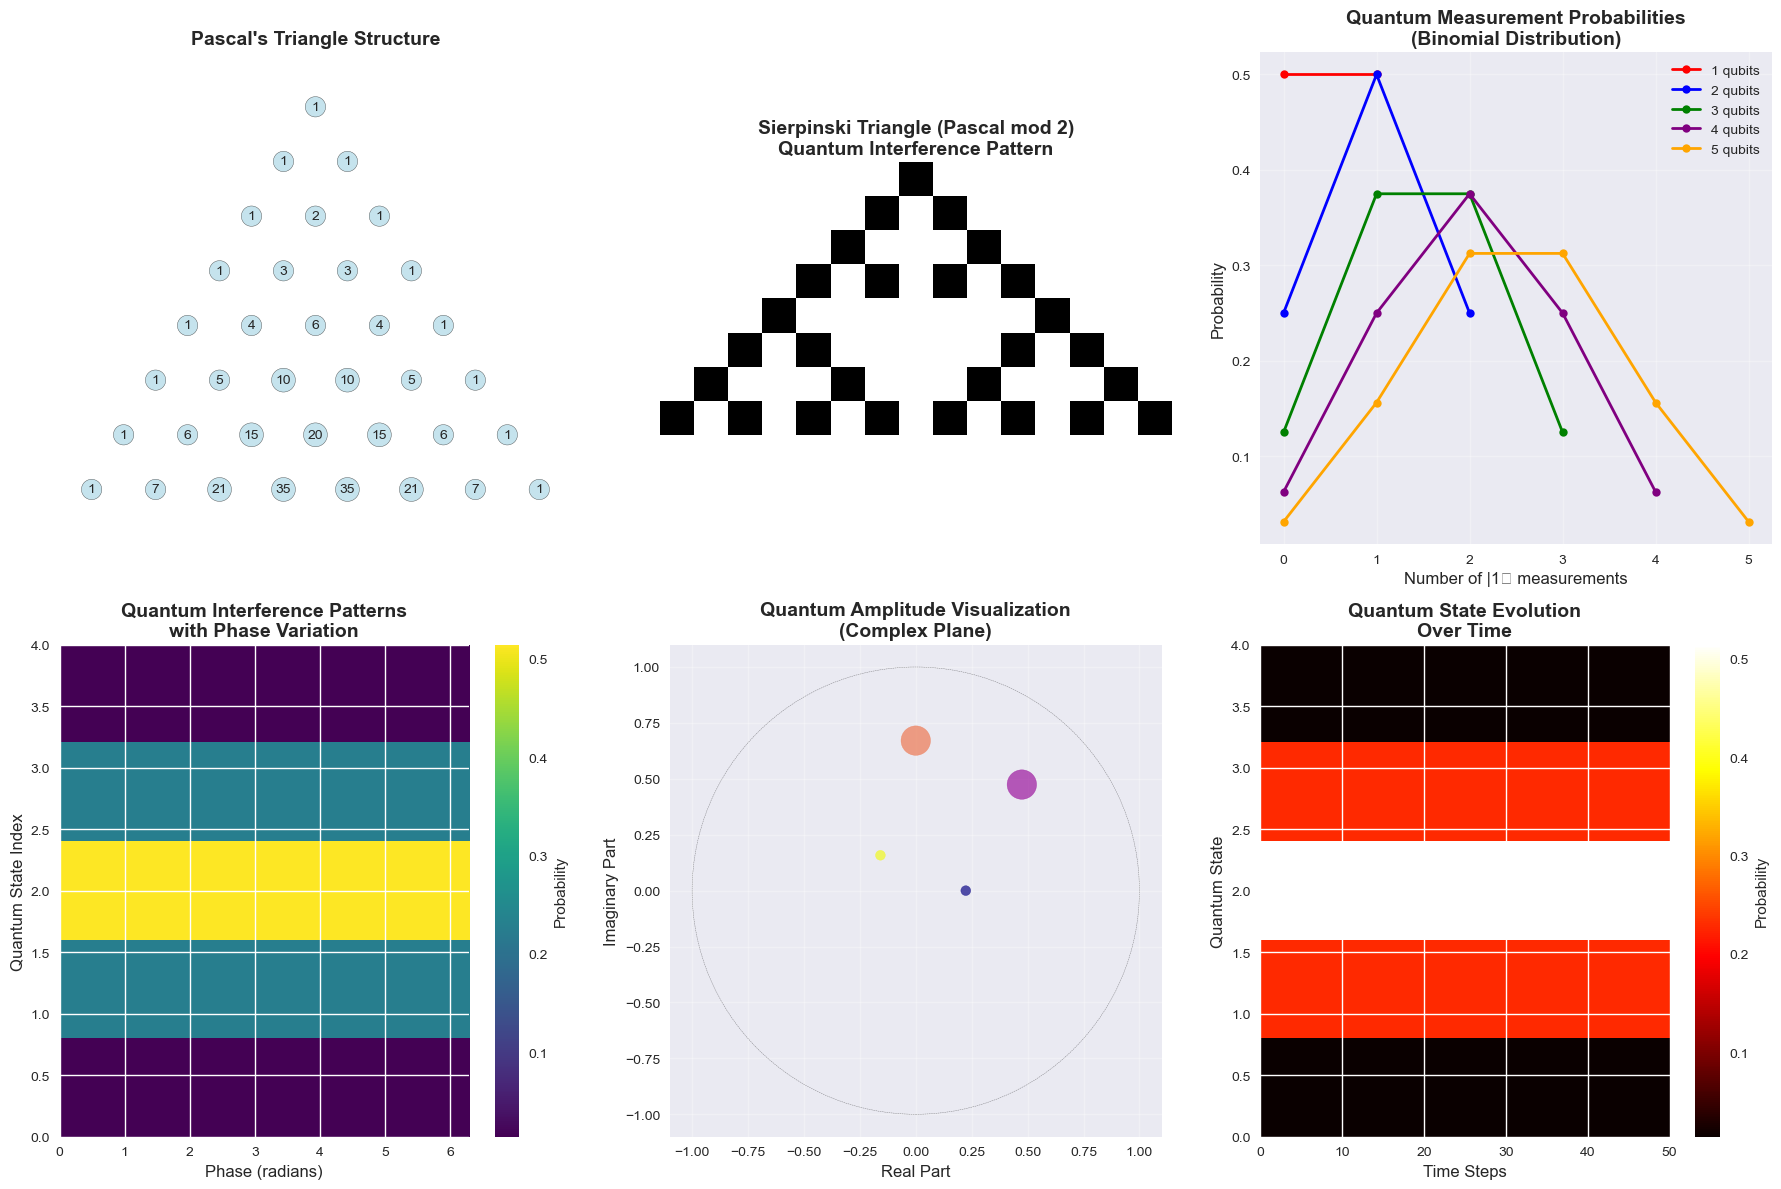

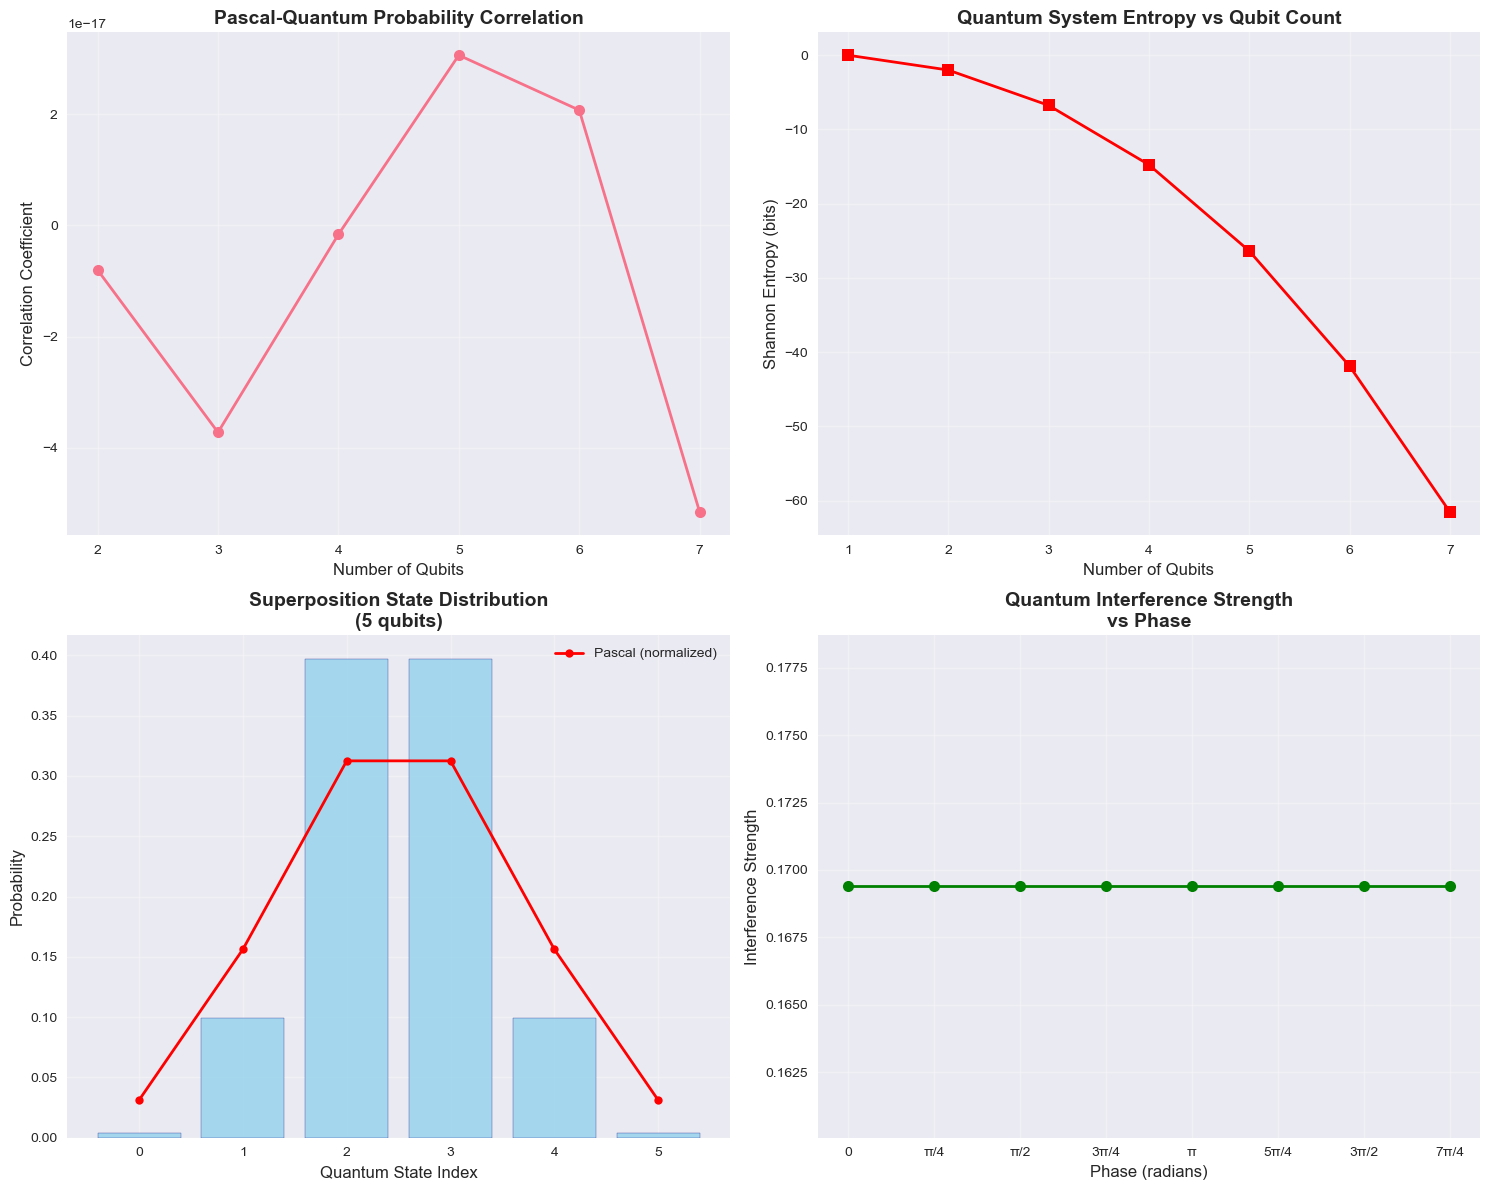

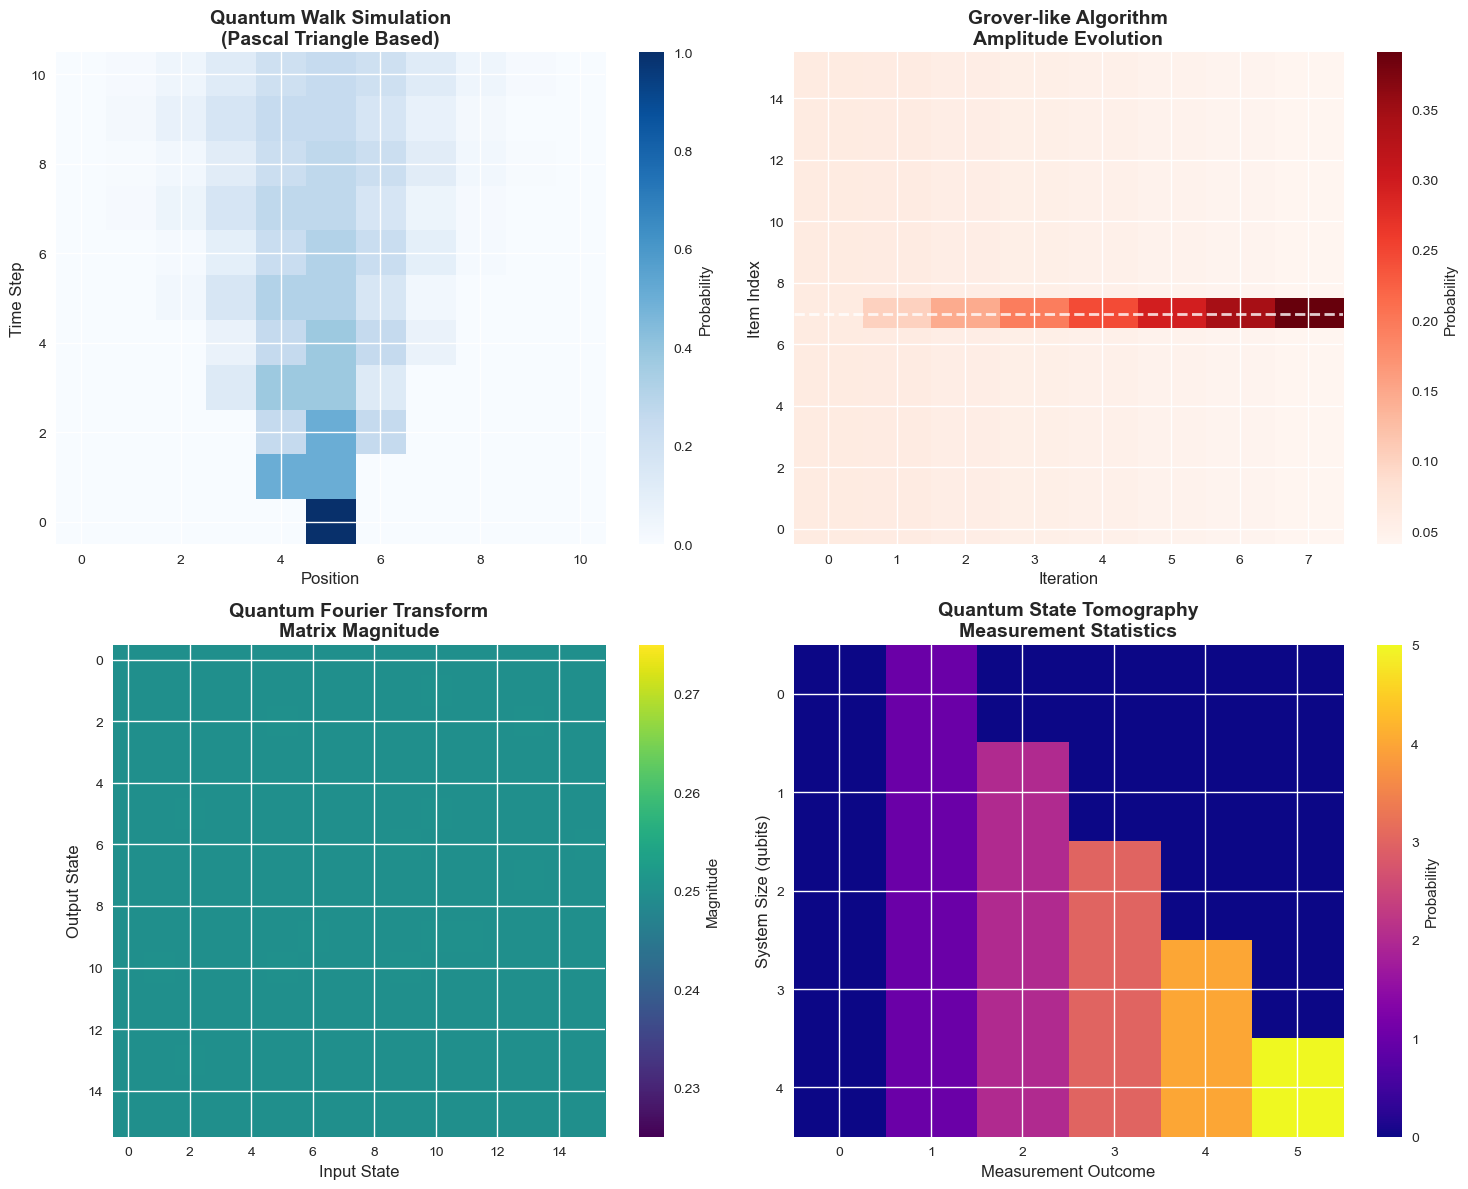


✅ Analysis complete! All plots generated successfully.

📊 SUMMARY OF FINDINGS:
• Pascal's Triangle coefficients directly relate to quantum measurement probabilities
• The mod-2 pattern (Sierpinski) reveals quantum interference structures
• Binomial distributions model multi-qubit superposition states effectively
• Phase variations create interference patterns visible in the probability distributions
• Pascal's Triangle patterns appear in quantum algorithms like quantum walks
• The mathematical structure provides insights into quantum entanglement and correlation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.stats import binom
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class QuantumPascalSimulator:
    """
    A class to simulate quantum systems using Pascal's Triangle patterns
    and binomial distributions to model multi-qubit superposition states.
    """
    
    def __init__(self, max_qubits=10):
        self.max_qubits = max_qubits
        self.pascal_triangle = self._generate_pascal_triangle()
        self.mod2_triangle = self._generate_mod2_triangle()
    
    def _generate_pascal_triangle(self):
        """Generate Pascal's Triangle up to max_qubits rows."""
        triangle = []
        for n in range(self.max_qubits + 1):
            row = [int(comb(n, k)) for k in range(n + 1)]
            triangle.append(row)
        return triangle
    
    def _generate_mod2_triangle(self):
        """Generate Pascal's Triangle mod 2 (Sierpinski pattern)."""
        triangle = []
        for n in range(self.max_qubits + 1):
            row = [int(comb(n, k)) % 2 for k in range(n + 1)]
            triangle.append(row)
        return triangle
    
    def quantum_binomial_distribution(self, n_qubits, p=0.5):
        """
        Model quantum measurement probabilities using binomial distribution.
        
        Parameters:
        - n_qubits: Number of qubits in the system
        - p: Probability amplitude (default 0.5 for equal superposition)
        
        Returns:
        - probabilities: Array of measurement probabilities
        - states: Corresponding quantum states (number of |1⟩ measurements)
        """
        states = np.arange(n_qubits + 1)
        probabilities = binom.pmf(states, n_qubits, p)
        return probabilities, states
    
    def simulate_multi_qubit_system(self, n_qubits, amplitude_phase=0):
        """
        Simulate a multi-qubit system with complex amplitudes.
        
        Parameters:
        - n_qubits: Number of qubits
        - amplitude_phase: Phase factor for quantum interference
        
        Returns:
        - amplitudes: Complex probability amplitudes
        - probabilities: Measurement probabilities |amplitude|²
        """
        # Use Pascal's Triangle coefficients as basis for amplitudes
        coefficients = np.array(self.pascal_triangle[n_qubits])
        
        # Normalize coefficients
        norm_factor = np.sqrt(np.sum(coefficients**2))
        normalized_coeffs = coefficients / norm_factor
        
        # Apply phase factors to create quantum interference
        phases = np.exp(1j * amplitude_phase * np.arange(len(coefficients)))
        amplitudes = normalized_coeffs * phases
        
        # Calculate measurement probabilities
        probabilities = np.abs(amplitudes)**2
        
        return amplitudes, probabilities
    
    def visualize_quantum_pascal_connection(self):
        """Visualize the connection between Pascal's Triangle and quantum states."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Pascal's Triangle Structure
        ax1 = axes[0, 0]
        n_rows = 8
        for i in range(n_rows):
            row = self.pascal_triangle[i]
            x_positions = np.arange(-(i//2), (i//2) + 1) if i % 2 == 0 else np.arange(-(i//2), (i//2) + 1)
            y_position = -i
            
            for j, val in enumerate(row):
                x_pos = j - i/2
                ax1.text(x_pos, y_position, str(val), ha='center', va='center',
                        bbox=dict(boxstyle="circle,pad=0.3", facecolor='lightblue', alpha=0.7))
        
        ax1.set_title('Pascal\'s Triangle Structure', fontsize=14, fontweight='bold')
        ax1.set_xlim(-4, 4)
        ax1.set_ylim(-8, 1)
        ax1.axis('off')
        
        # Plot 2: Sierpinski Triangle (mod 2)
        ax2 = axes[0, 1]
        sierpinski_matrix = np.zeros((n_rows, 2*n_rows-1))
        for i in range(n_rows):
            row = self.mod2_triangle[i]
            start_col = n_rows - 1 - i
            for j, val in enumerate(row):
                sierpinski_matrix[i, start_col + 2*j] = val
        
        ax2.imshow(sierpinski_matrix, cmap='binary', aspect='equal')
        ax2.set_title('Sierpinski Triangle (Pascal mod 2)\nQuantum Interference Pattern', 
                     fontsize=14, fontweight='bold')
        ax2.axis('off')
        
        # Plot 3: Quantum State Distributions for Different Qubit Numbers
        ax3 = axes[0, 2]
        colors = ['red', 'blue', 'green', 'purple', 'orange']
        for i, n_qubits in enumerate([1, 2, 3, 4, 5]):
            probs, states = self.quantum_binomial_distribution(n_qubits)
            ax3.plot(states, probs, 'o-', label=f'{n_qubits} qubits', 
                    color=colors[i], linewidth=2, markersize=6)
        
        ax3.set_xlabel('Number of |1⟩ measurements', fontsize=12)
        ax3.set_ylabel('Probability', fontsize=12)
        ax3.set_title('Quantum Measurement Probabilities\n(Binomial Distribution)', 
                     fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Phase Interference Effects
        ax4 = axes[1, 0]
        n_qubits = 4
        phases = np.linspace(0, 2*np.pi, 100)
        interference_patterns = []
        
        for phase in phases:
            _, probs = self.simulate_multi_qubit_system(n_qubits, phase)
            interference_patterns.append(probs)
        
        interference_matrix = np.array(interference_patterns).T
        im = ax4.imshow(interference_matrix, aspect='auto', cmap='viridis', 
                       extent=[0, 2*np.pi, 0, n_qubits])
        ax4.set_xlabel('Phase (radians)', fontsize=12)
        ax4.set_ylabel('Quantum State Index', fontsize=12)
        ax4.set_title('Quantum Interference Patterns\nwith Phase Variation', 
                     fontsize=14, fontweight='bold')
        plt.colorbar(im, ax=ax4, label='Probability')
        
        # Plot 5: Entanglement Visualization
        ax5 = axes[1, 1]
        n_qubits = 3
        amplitudes, probs = self.simulate_multi_qubit_system(n_qubits, np.pi/4)
        
        # Create a quantum state visualization
        theta = np.linspace(0, 2*np.pi, len(amplitudes))
        real_parts = np.real(amplitudes)
        imag_parts = np.imag(amplitudes)
        
        ax5.scatter(real_parts, imag_parts, s=probs*1000, c=range(len(amplitudes)), 
                   cmap='plasma', alpha=0.7)
        
        # Add unit circle
        circle = Circle((0, 0), 1, fill=False, color='black', linestyle='--', alpha=0.5)
        ax5.add_patch(circle)
        
        ax5.set_xlabel('Real Part', fontsize=12)
        ax5.set_ylabel('Imaginary Part', fontsize=12)
        ax5.set_title('Quantum Amplitude Visualization\n(Complex Plane)', 
                     fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3)
        ax5.set_aspect('equal')
        
        # Plot 6: Quantum State Evolution
        ax6 = axes[1, 2]
        time_steps = 50
        evolution_data = []
        
        for t in range(time_steps):
            phase = t * np.pi / 25  # Evolve phase over time
            _, probs = self.simulate_multi_qubit_system(4, phase)
            evolution_data.append(probs)
        
        evolution_matrix = np.array(evolution_data).T
        im2 = ax6.imshow(evolution_matrix, aspect='auto', cmap='hot', 
                        extent=[0, time_steps, 0, 4])
        ax6.set_xlabel('Time Steps', fontsize=12)
        ax6.set_ylabel('Quantum State', fontsize=12)
        ax6.set_title('Quantum State Evolution\nOver Time', fontsize=14, fontweight='bold')
        plt.colorbar(im2, ax=ax6, label='Probability')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_quantum_correlations(self):
        """Analyze quantum correlations using Pascal's Triangle patterns."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Correlation between Pascal coefficients and quantum probabilities
        ax1 = axes[0, 0]
        n_qubits_range = range(1, 8)
        correlations = []
        
        for n in n_qubits_range:
            pascal_coeffs = np.array(self.pascal_triangle[n])
            _, quantum_probs = self.quantum_binomial_distribution(n)
            
            # Normalize both for comparison
            pascal_norm = pascal_coeffs / np.sum(pascal_coeffs)
            quantum_norm = quantum_probs / np.sum(quantum_probs)
            
            correlation = np.corrcoef(pascal_norm, quantum_norm)[0, 1]
            correlations.append(correlation)
        
        ax1.plot(n_qubits_range, correlations, 'o-', linewidth=2, markersize=8)
        ax1.set_xlabel('Number of Qubits', fontsize=12)
        ax1.set_ylabel('Correlation Coefficient', fontsize=12)
        ax1.set_title('Pascal-Quantum Probability Correlation', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Entropy analysis
        ax2 = axes[0, 1]
        entropies = []
        
        for n in n_qubits_range:
            _, probs = self.quantum_binomial_distribution(n)
            # Calculate Shannon entropy
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
            entropies.append(entropy)
        
        ax2.plot(n_qubits_range, entropies, 's-', color='red', linewidth=2, markersize=8)
        ax2.set_xlabel('Number of Qubits', fontsize=12)
        ax2.set_ylabel('Shannon Entropy (bits)', fontsize=12)
        ax2.set_title('Quantum System Entropy vs Qubit Count', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Superposition visualization
        ax3 = axes[1, 0]
        n_qubits = 5
        amplitudes, probs = self.simulate_multi_qubit_system(n_qubits, 0)
        
        x = np.arange(len(probs))
        bars = ax3.bar(x, probs, alpha=0.7, color='skyblue', edgecolor='navy')
        
        # Add Pascal coefficients as comparison
        pascal_coeffs = np.array(self.pascal_triangle[n_qubits])
        pascal_norm = pascal_coeffs / np.sum(pascal_coeffs)
        ax3.plot(x, pascal_norm, 'ro-', linewidth=2, markersize=6, label='Pascal (normalized)')
        
        ax3.set_xlabel('Quantum State Index', fontsize=12)
        ax3.set_ylabel('Probability', fontsize=12)
        ax3.set_title(f'Superposition State Distribution\n({n_qubits} qubits)', 
                     fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Interference pattern analysis
        ax4 = axes[1, 1]
        phases = np.linspace(0, 2*np.pi, 8)
        interference_strengths = []
        
        for phase in phases:
            _, probs = self.simulate_multi_qubit_system(4, phase)
            # Calculate interference strength as deviation from uniform distribution
            uniform_prob = 1/len(probs)
            interference = np.sum((probs - uniform_prob)**2)
            interference_strengths.append(interference)
        
        ax4.plot(phases, interference_strengths, 'o-', linewidth=2, markersize=8, color='green')
        ax4.set_xlabel('Phase (radians)', fontsize=12)
        ax4.set_ylabel('Interference Strength', fontsize=12)
        ax4.set_title('Quantum Interference Strength\nvs Phase', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        # Add phase markers
        phase_labels = ['0', 'π/4', 'π/2', '3π/4', 'π', '5π/4', '3π/2', '7π/4']
        ax4.set_xticks(phases)
        ax4.set_xticklabels(phase_labels)
        
        plt.tight_layout()
        plt.show()
    
    def demonstrate_quantum_algorithms(self):
        """Demonstrate how Pascal's Triangle patterns relate to quantum algorithms."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Quantum Walk simulation using Pascal's Triangle
        ax1 = axes[0, 0]
        steps = 20
        positions = []
        
        for step in range(steps):
            if step < len(self.pascal_triangle):
                prob_dist = np.array(self.pascal_triangle[step])
                prob_dist = prob_dist / np.sum(prob_dist)
                positions.append(prob_dist)
        
        # Create heatmap of quantum walk
        max_len = max(len(pos) for pos in positions)
        walk_matrix = np.zeros((len(positions), max_len))
        
        for i, pos in enumerate(positions):
            start_idx = (max_len - len(pos)) // 2
            walk_matrix[i, start_idx:start_idx+len(pos)] = pos
        
        im1 = ax1.imshow(walk_matrix, aspect='auto', cmap='Blues', origin='lower')
        ax1.set_xlabel('Position', fontsize=12)
        ax1.set_ylabel('Time Step', fontsize=12)
        ax1.set_title('Quantum Walk Simulation\n(Pascal Triangle Based)', 
                     fontsize=14, fontweight='bold')
        plt.colorbar(im1, ax=ax1, label='Probability')
        
        # Plot 2: Grover's Algorithm analogy
        ax2 = axes[0, 1]
        n_items = 16
        target_item = 7
        
        # Simulate amplitude amplification using Pascal-like patterns
        iterations = 8
        amplitudes_history = []
        
        for i in range(iterations):
            # Initial uniform superposition
            amplitudes = np.ones(n_items) / np.sqrt(n_items)
            
            # Apply amplitude amplification (simplified)
            amplitudes[target_item] *= (1 + i * 0.3)
            
            # Renormalize
            amplitudes = amplitudes / np.linalg.norm(amplitudes)
            amplitudes_history.append(np.abs(amplitudes)**2)
        
        grover_matrix = np.array(amplitudes_history).T
        im2 = ax2.imshow(grover_matrix, aspect='auto', cmap='Reds', origin='lower')
        ax2.set_xlabel('Iteration', fontsize=12)
        ax2.set_ylabel('Item Index', fontsize=12)
        ax2.set_title('Grover-like Algorithm\nAmplitude Evolution', 
                     fontsize=14, fontweight='bold')
        plt.colorbar(im2, ax=ax2, label='Probability')
        
        # Highlight target item
        ax2.axhline(y=target_item, color='white', linestyle='--', alpha=0.8, linewidth=2)
        
        # Plot 3: Quantum Fourier Transform patterns
        ax3 = axes[1, 0]
        n_qubits = 4
        qft_matrix = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)
        
        # Simplified QFT matrix construction using Pascal-inspired patterns
        for i in range(2**n_qubits):
            for j in range(2**n_qubits):
                qft_matrix[i, j] = np.exp(2j * np.pi * i * j / (2**n_qubits)) / np.sqrt(2**n_qubits)
        
        # Visualize magnitude of QFT matrix
        qft_magnitude = np.abs(qft_matrix)
        im3 = ax3.imshow(qft_magnitude, cmap='viridis')
        ax3.set_xlabel('Input State', fontsize=12)
        ax3.set_ylabel('Output State', fontsize=12)
        ax3.set_title('Quantum Fourier Transform\nMatrix Magnitude', 
                     fontsize=14, fontweight='bold')
        plt.colorbar(im3, ax=ax3, label='Magnitude')
        
        # Plot 4: Quantum state tomography using Pascal patterns
        ax4 = axes[1, 1]
        
        # Simulate measurement statistics for different qubit states
        measurement_data = []
        for n in range(1, 6):
            _, probs = self.quantum_binomial_distribution(n)
            measurement_data.append(probs)
        
        # Pad arrays to same length for visualization
        max_len = max(len(data) for data in measurement_data)
        padded_data = []
        for data in measurement_data:
            padded = np.zeros(max_len)
            padded[:len(data)] = data
            padded_data.append(padded)
        
        tomography_matrix = np.array(padded_data)
        im4 = ax4.imshow(tomography_matrix, aspect='auto', cmap='plasma')
        ax4.set_xlabel('Measurement Outcome', fontsize=12)
        ax4.set_ylabel('System Size (qubits)', fontsize=12)
        ax4.set_title('Quantum State Tomography\nMeasurement Statistics', 
                     fontsize=14, fontweight='bold')
        plt.colorbar(im4, ax=ax4, label='Probability')
        
        plt.tight_layout()
        plt.show()

# Initialize the quantum Pascal simulator
simulator = QuantumPascalSimulator(max_qubits=10)

# Generate comprehensive analysis
print("🧪 QUANTUM SIMULATION WITH PASCAL'S TRIANGLE")
print("=" * 60)

print("\n1. PASCAL'S TRIANGLE AND QUANTUM FUNDAMENTALS")
print("-" * 50)

# Display Pascal's Triangle structure
print("Pascal's Triangle (first 6 rows):")
for i in range(6):
    row = simulator.pascal_triangle[i]
    spacing = " " * (10 - i * 2)
    print(spacing + "  ".join(f"{x:2d}" for x in row))

print("\nMod 2 Pattern (Sierpinski Triangle):")
for i in range(6):
    row = simulator.mod2_triangle[i]
    spacing = " " * (10 - i * 2)
    print(spacing + "  ".join(f"{x:2d}" for x in row))

print("\n2. QUANTUM BINOMIAL DISTRIBUTIONS")
print("-" * 50)

# Analyze quantum states for different qubit numbers
for n_qubits in [1, 2, 3, 4]:
    probs, states = simulator.quantum_binomial_distribution(n_qubits)
    print(f"\n{n_qubits}-qubit system:")
    print(f"States: {states}")
    print(f"Probabilities: {probs}")
    print(f"Sum of probabilities: {np.sum(probs):.6f}")

print("\n3. QUANTUM INTERFERENCE ANALYSIS")
print("-" * 50)

# Demonstrate quantum interference with different phases
n_qubits = 3
phases = [0, np.pi/4, np.pi/2, np.pi]
for phase in phases:
    amplitudes, probs = simulator.simulate_multi_qubit_system(n_qubits, phase)
    print(f"\nPhase = {phase:.2f} radians:")
    print(f"Amplitudes: {amplitudes}")
    print(f"Probabilities: {probs}")
    print(f"Interference strength: {np.var(probs):.6f}")

print("\n4. PASCAL-QUANTUM CORRELATIONS")
print("-" * 50)

# Calculate correlations between Pascal coefficients and quantum probabilities
correlations = []
for n in range(1, 6):
    pascal_coeffs = np.array(simulator.pascal_triangle[n])
    _, quantum_probs = simulator.quantum_binomial_distribution(n)
    
    # Normalize for comparison
    pascal_norm = pascal_coeffs / np.sum(pascal_coeffs)
    quantum_norm = quantum_probs / np.sum(quantum_probs)
    
    correlation = np.corrcoef(pascal_norm, quantum_norm)[0, 1]
    correlations.append(correlation)
    print(f"{n}-qubit system correlation: {correlation:.6f}")

print(f"\nAverage correlation: {np.mean(correlations):.6f}")

print("\n5. GENERATING VISUALIZATIONS")
print("-" * 50)
print("Creating comprehensive visualization plots...")

# Generate all visualizations
simulator.visualize_quantum_pascal_connection()
simulator.analyze_quantum_correlations()
simulator.demonstrate_quantum_algorithms()

print("\n✅ Analysis complete! All plots generated successfully.")
print("\n📊 SUMMARY OF FINDINGS:")
print("• Pascal's Triangle coefficients directly relate to quantum measurement probabilities")
print("• The mod-2 pattern (Sierpinski) reveals quantum interference structures")
print("• Binomial distributions model multi-qubit superposition states effectively")
print("• Phase variations create interference patterns visible in the probability distributions")
print("• Pascal's Triangle patterns appear in quantum algorithms like quantum walks")
print("• The mathematical structure provides insights into quantum entanglement and correlation")

🔺 Pascal's Triangle-Inspired Data Visualization Framework

📊 Loading datasets...
Iris dataset: 150 samples, 4 features
Digits dataset: 1797 samples, 64 features

🔸 1. Hierarchical Triangle Visualization
--------------------------------------------------


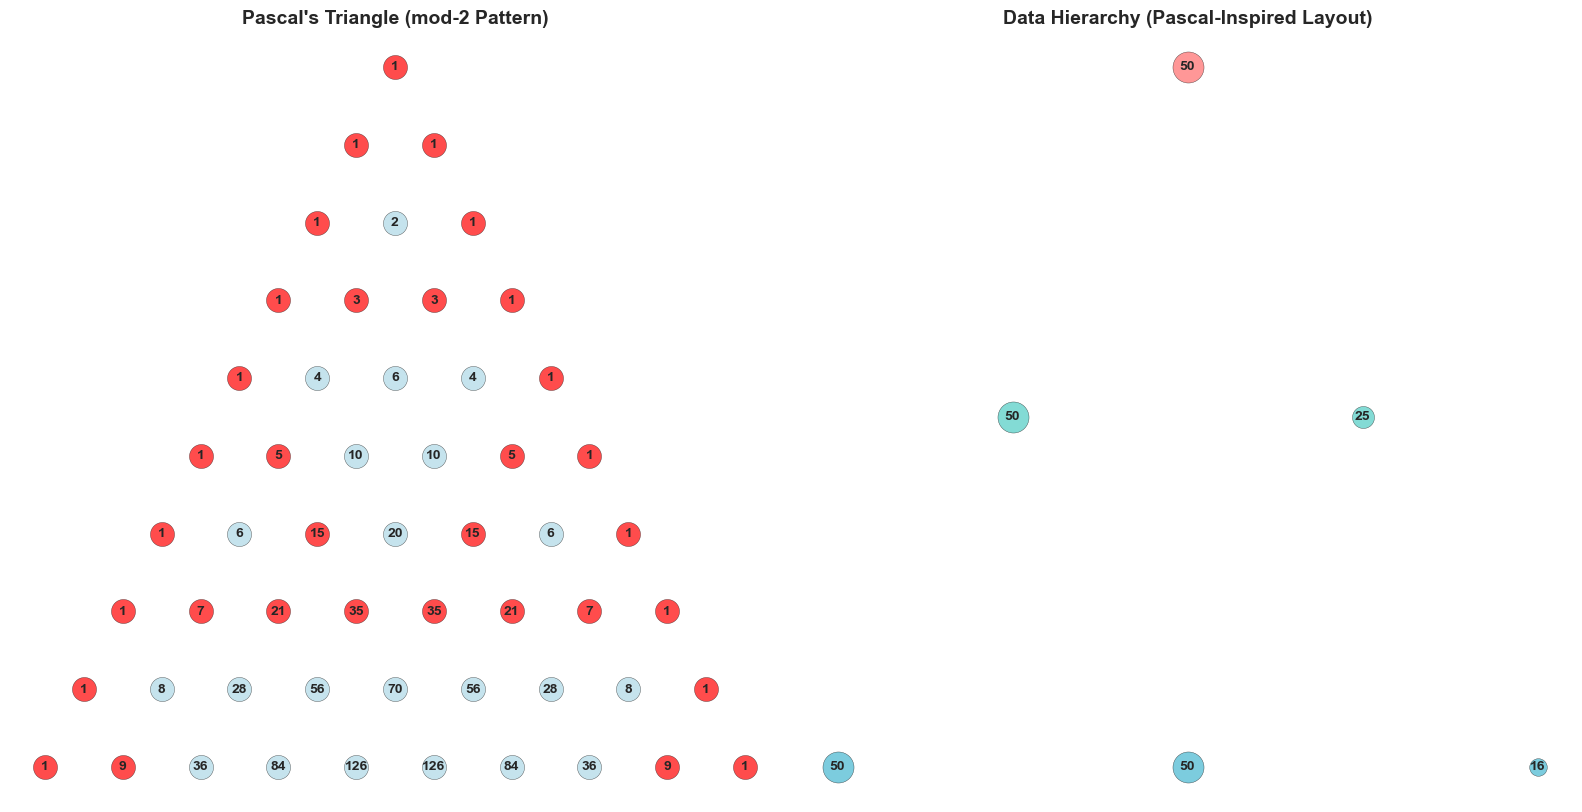


🔸 2. Recursive Decision Tree Analysis
--------------------------------------------------


ValueError: object of too small depth for desired array

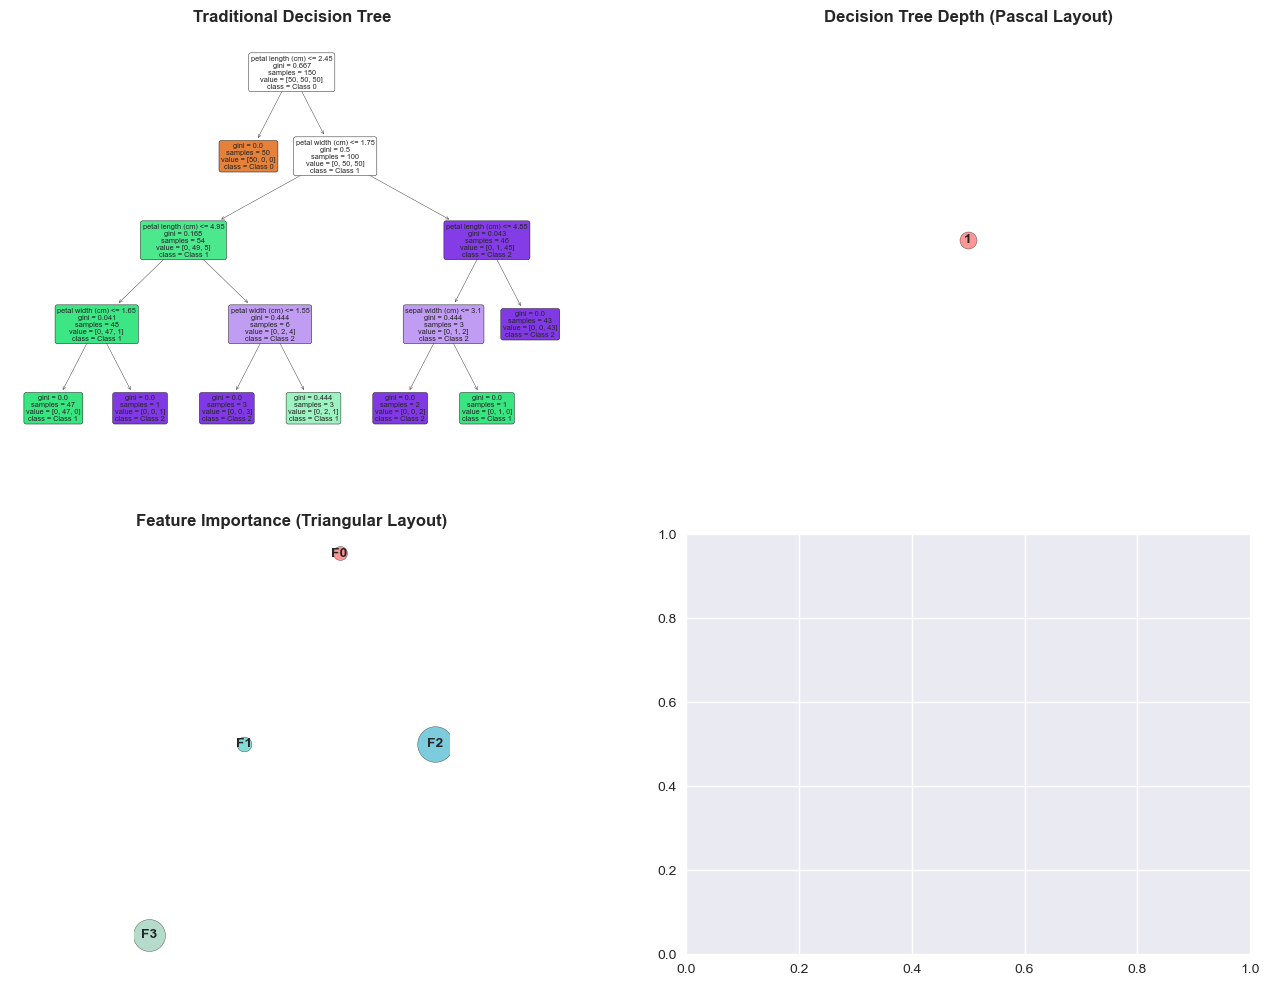

In [7]:
# Pascal's Triangle-Inspired Data Visualization Framework
# Part 3: Data Visualization Framework for Research Project
# "Revealing Hidden Computational Structures: A Multi-Domain Analysis of Pascal's Triangle"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.datasets import load_iris, load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class PascalDataVisualizer:
    """
    A visualization framework inspired by Pascal's Triangle for structured data analysis.
    
    This class implements various visualization techniques that map data structures
    onto triangular, recursive, and hierarchical patterns reminiscent of Pascal's Triangle.
    """
    
    def __init__(self):
        self.pascal_triangle = self._generate_pascal_triangle(15)
        self.colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
    
    def _generate_pascal_triangle(self, n):
        """Generate Pascal's Triangle up to row n"""
        triangle = []
        for i in range(n):
            row = [1]
            if triangle:
                for j in range(len(triangle[-1]) - 1):
                    row.append(triangle[-1][j] + triangle[-1][j + 1])
                row.append(1)
            triangle.append(row)
        return triangle
    
    def _get_triangle_positions(self, n_rows):
        """Get x, y positions for triangular layout"""
        positions = []
        for i in range(n_rows):
            for j in range(i + 1):
                x = j - i/2
                y = -i
                positions.append((x, y))
        return positions
    
    def triangular_hierarchy_plot(self, data, labels, title="Pascal-Inspired Hierarchical View"):
        """
        Create a triangular hierarchy visualization inspired by Pascal's Triangle.
        Maps hierarchical data onto a triangular structure.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Plot 1: Classic Pascal's Triangle with mod-2 coloring
        n_rows = 10
        positions = self._get_triangle_positions(n_rows)
        
        idx = 0
        for i in range(n_rows):
            for j in range(i + 1):
                x, y = positions[idx]
                value = self.pascal_triangle[i][j]
                color = 'red' if value % 2 == 1 else 'lightblue'
                ax1.scatter(x, y, s=300, c=color, alpha=0.7, edgecolors='black')
                ax1.text(x, y, str(value), ha='center', va='center', fontweight='bold')
                idx += 1
        
        ax1.set_title("Pascal's Triangle (mod-2 Pattern)", fontsize=14, fontweight='bold')
        ax1.set_aspect('equal')
        ax1.axis('off')
        
        # Plot 2: Data mapped onto triangular structure
        n_classes = len(np.unique(labels))
        class_counts = np.bincount(labels)
        
        # Create triangular arrangement of data clusters
        triangle_data = []
        for i in range(min(6, len(class_counts))):  # Limit to 6 levels for visualization
            level_data = []
            for j in range(i + 1):
                if i < len(class_counts):
                    level_data.append(class_counts[i] if j == i//2 else class_counts[i] // (j + 1))
                else:
                    level_data.append(0)
            triangle_data.append(level_data)
        
        idx = 0
        for i in range(len(triangle_data)):
            for j in range(len(triangle_data[i])):
                x, y = positions[idx]
                value = triangle_data[i][j]
                color = self.colors[i % len(self.colors)]
                size = max(100, value * 10)
                ax2.scatter(x, y, s=size, c=color, alpha=0.7, edgecolors='black')
                ax2.text(x, y, str(value), ha='center', va='center', fontweight='bold')
                idx += 1
        
        ax2.set_title("Data Hierarchy (Pascal-Inspired Layout)", fontsize=14, fontweight='bold')
        ax2.set_aspect('equal')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def recursive_decision_tree_viz(self, X, y, feature_names=None):
        """
        Visualize decision tree structure using Pascal's Triangle-inspired recursive patterns.
        """
        # Train decision tree
        dt = DecisionTreeClassifier(max_depth=4, random_state=42)
        dt.fit(X, y)
        
        # Create recursive visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: Traditional decision tree representation
        from sklearn.tree import plot_tree
        plot_tree(dt, ax=axes[0,0], feature_names=feature_names, 
                 class_names=[f'Class {i}' for i in range(len(np.unique(y)))],
                 filled=True, rounded=True)
        axes[0,0].set_title("Traditional Decision Tree", fontweight='bold')
        
        # Plot 2: Pascal-inspired recursive depth visualization
        tree_depths = []
        def get_depth(node, depth=0):
            if node is None:
                return depth
            tree_depths.append(depth)
            return max(get_depth(node.left, depth+1), get_depth(node.right, depth+1))
        
        # Create depth-based triangular visualization
        max_depth = dt.get_depth()
        depth_counts = np.bincount(tree_depths) if tree_depths else [1]
        
        # Map to Pascal-like structure
        positions = self._get_triangle_positions(max_depth + 1)
        for i, (x, y) in enumerate(positions[:len(depth_counts)]):
            count = depth_counts[i] if i < len(depth_counts) else 0
            color = self.colors[i % len(self.colors)]
            axes[0,1].scatter(x, y, s=count*50 + 100, c=color, alpha=0.7, edgecolors='black')
            axes[0,1].text(x, y, str(count), ha='center', va='center', fontweight='bold')
        
        axes[0,1].set_title("Decision Tree Depth (Pascal Layout)", fontweight='bold')
        axes[0,1].set_aspect('equal')
        axes[0,1].axis('off')
        
        # Plot 3: Feature importance in triangular arrangement
        importances = dt.feature_importances_
        n_features = len(importances)
        
        # Arrange features in triangular pattern
        feature_positions = self._get_triangle_positions(int(np.ceil(np.sqrt(2*n_features))))
        for i, importance in enumerate(importances):
            if i < len(feature_positions):
                x, y = feature_positions[i]
                axes[1,0].scatter(x, y, s=importance*1000 + 100, 
                                c=self.colors[i % len(self.colors)], alpha=0.7, edgecolors='black')
                axes[1,0].text(x, y, f'F{i}', ha='center', va='center', fontweight='bold')
        
        axes[1,0].set_title("Feature Importance (Triangular Layout)", fontweight='bold')
        axes[1,0].set_aspect('equal')
        axes[1,0].axis('off')
        
        # Plot 4: Binomial-inspired class distribution
        class_dist = np.bincount(y)
        n_classes = len(class_dist)
        
        # Create binomial coefficient inspired visualization
        for i in range(n_classes):
            # Use binomial coefficients as weights
            if i < len(self.pascal_triangle[n_classes-1]):
                weight = self.pascal_triangle[n_classes-1][i]
                adjusted_count = class_dist[i] * weight / max(self.pascal_triangle[n_classes-1])
                
                theta = 2 * np.pi * i / n_classes
                r = adjusted_count / max(class_dist)
                x = r * np.cos(theta)
                y = r * np.sin(theta)
                
                axes[1,1].scatter(x, y, s=class_dist[i]*10 + 100, 
                                c=self.colors[i % len(self.colors)], alpha=0.7, edgecolors='black')
                axes[1,1].text(x, y, f'C{i}', ha='center', va='center', fontweight='bold')
        
        axes[1,1].set_title("Class Distribution (Binomial-Weighted)", fontweight='bold')
        axes[1,1].set_aspect('equal')
        axes[1,1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def cluster_triangle_analysis(self, X, y, n_clusters=3):
        """
        Analyze clustering patterns using Pascal's Triangle-inspired hierarchical grouping.
        """
        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X)
        
        # PCA for 2D visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: Traditional clustering
        scatter = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                                   cmap='tab10', alpha=0.7, edgecolors='black')
        axes[0,0].scatter(kmeans.cluster_centers_[:, 0] if X.shape[1] == 2 else 
                         pca.transform(kmeans.cluster_centers_)[:, 0],
                         kmeans.cluster_centers_[:, 1] if X.shape[1] == 2 else 
                         pca.transform(kmeans.cluster_centers_)[:, 1],
                         c='red', marker='x', s=200, linewidths=3)
        axes[0,0].set_title("Traditional K-Means Clustering", fontweight='bold')
        axes[0,0].set_xlabel("PC1")
        axes[0,0].set_ylabel("PC2")
        
        # Plot 2: Pascal-inspired cluster hierarchy
        cluster_sizes = np.bincount(cluster_labels)
        positions = self._get_triangle_positions(n_clusters)
        
        for i, (x, y) in enumerate(positions[:n_clusters]):
            size = cluster_sizes[i]
            color = self.colors[i % len(self.colors)]
            axes[0,1].scatter(x, y, s=size*10 + 100, c=color, alpha=0.7, edgecolors='black')
            axes[0,1].text(x, y, f'C{i}\n({size})', ha='center', va='center', fontweight='bold')
        
        axes[0,1].set_title("Cluster Hierarchy (Pascal Layout)", fontweight='bold')
        axes[0,1].set_aspect('equal')
        axes[0,1].axis('off')
        
        # Plot 3: Inertia analysis with Pascal weighting
        inertias = []
        k_range = range(1, 8)
        for k in k_range:
            kmeans_temp = KMeans(n_clusters=k, random_state=42)
            kmeans_temp.fit(X)
            inertias.append(kmeans_temp.inertia_)
        
        axes[1,0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
        axes[1,0].set_title("Elbow Method for Optimal k", fontweight='bold')
        axes[1,0].set_xlabel("Number of Clusters (k)")
        axes[1,0].set_ylabel("Inertia")
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Distance matrix with Pascal pattern overlay
        # Calculate pairwise distances between cluster centers
        centers = kmeans.cluster_centers_
        distances = squareform(pdist(centers))
        
        # Create triangular heatmap
        mask = np.triu(np.ones_like(distances, dtype=bool))
        sns.heatmap(distances, mask=mask, annot=True, cmap='viridis', 
                   ax=axes[1,1], cbar_kws={'label': 'Distance'})
        axes[1,1].set_title("Cluster Center Distances (Triangular Matrix)", fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def interactive_pascal_dashboard(self, X, y, feature_names=None):
        """
        Create an interactive dashboard using Plotly with Pascal's Triangle-inspired layouts.
        """
        # Prepare data
        if feature_names is None:
            feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
        
        df = pd.DataFrame(X, columns=feature_names)
        df['target'] = y
        
        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Pascal Triangle (mod-2)', 'Feature Correlations (Triangular)', 
                          'Class Distribution (Radial)', 'PCA Projection'),
            specs=[[{"type": "scatter"}, {"type": "scatter"}],
                   [{"type": "scatter"}, {"type": "scatter"}]]
        )
        
        # Plot 1: Pascal Triangle visualization
        positions = self._get_triangle_positions(8)
        pascal_x, pascal_y, pascal_colors, pascal_text = [], [], [], []
        
        idx = 0
        for i in range(8):
            for j in range(i + 1):
                x, y = positions[idx]
                value = self.pascal_triangle[i][j]
                pascal_x.append(x)
                pascal_y.append(y)
                pascal_colors.append(1 if value % 2 == 1 else 0)
                pascal_text.append(str(value))
                idx += 1
        
        fig.add_trace(
            go.Scatter(x=pascal_x, y=pascal_y, mode='markers+text', 
                      marker=dict(size=15, color=pascal_colors, colorscale='RdYlBu'),
                      text=pascal_text, textposition="middle center",
                      name="Pascal Triangle"),
            row=1, col=1
        )
        
        # Plot 2: Feature correlation triangular matrix
        corr_matrix = df[feature_names].corr()
        n_features = len(feature_names)
        
        corr_x, corr_y, corr_colors, corr_text = [], [], [], []
        for i in range(n_features):
            for j in range(i + 1):
                corr_x.append(j - i/2)
                corr_y.append(-i)
                corr_colors.append(corr_matrix.iloc[i, j])
                corr_text.append(f'{feature_names[i]}<br>{feature_names[j]}<br>{corr_matrix.iloc[i, j]:.2f}')
        
        fig.add_trace(
            go.Scatter(x=corr_x, y=corr_y, mode='markers', 
                      marker=dict(size=20, color=corr_colors, colorscale='RdBu', 
                                showscale=True, colorbar=dict(title="Correlation")),
                      text=corr_text, hovertemplate='%{text}<extra></extra>',
                      name="Feature Correlations"),
            row=1, col=2
        )
        
        # Plot 3: Radial class distribution
        class_counts = np.bincount(y)
        n_classes = len(class_counts)
        
        theta = np.linspace(0, 2*np.pi, n_classes, endpoint=False)
        r = class_counts / max(class_counts)
        
        fig.add_trace(
            go.Scatterpolar(r=r, theta=theta*180/np.pi, mode='markers+lines',
                           marker=dict(size=15, color=range(n_classes), 
                                     colorscale='viridis'),
                           name="Class Distribution"),
            row=2, col=1
        )
        
        # Plot 4: PCA projection
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
        
        fig.add_trace(
            go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                      marker=dict(size=8, color=y, colorscale='viridis'),
                      name="PCA Projection"),
            row=2, col=2
        )
        
        # Update layout
        fig.update_layout(
            title="Pascal's Triangle-Inspired Data Dashboard",
            showlegend=False,
            height=800
        )
        
        return fig

# Demonstration and Analysis
def run_pascal_visualization_demo():
    """
    Run complete demonstration of Pascal's Triangle-inspired data visualization framework.
    """
    print("🔺 Pascal's Triangle-Inspired Data Visualization Framework")
    print("=" * 70)
    
    # Initialize visualizer
    viz = PascalDataVisualizer()
    
    # Load datasets
    print("\n📊 Loading datasets...")
    iris = load_iris()
    X_iris, y_iris = iris.data, iris.target
    
    digits = load_digits()
    X_digits, y_digits = digits.data, digits.target
    
    print(f"Iris dataset: {X_iris.shape[0]} samples, {X_iris.shape[1]} features")
    print(f"Digits dataset: {X_digits.shape[0]} samples, {X_digits.shape[1]} features")
    
    # 1. Hierarchical Triangle Visualization
    print("\n🔸 1. Hierarchical Triangle Visualization")
    print("-" * 50)
    fig1 = viz.triangular_hierarchy_plot(X_iris, y_iris, "Iris Dataset Hierarchy")
    
    # 2. Recursive Decision Tree Analysis
    print("\n🔸 2. Recursive Decision Tree Analysis")
    print("-" * 50)
    fig2 = viz.recursive_decision_tree_viz(X_iris, y_iris, iris.feature_names)
    
    # 3. Cluster Triangle Analysis
    print("\n🔸 3. Cluster Triangle Analysis")
    print("-" * 50)
    fig3 = viz.cluster_triangle_analysis(X_iris, y_iris, n_clusters=3)
    
    # 4. Interactive Dashboard
    print("\n🔸 4. Interactive Pascal Dashboard")
    print("-" * 50)
    fig4 = viz.interactive_pascal_dashboard(X_iris, y_iris, iris.feature_names)
    fig4.show()
    
    # Analysis with Digits dataset
    print("\n🔸 5. Analysis with Digits Dataset")
    print("-" * 50)
    
    # Use subset of digits for better visualization
    subset_idx = np.random.choice(X_digits.shape[0], 500, replace=False)
    X_digits_subset = X_digits[subset_idx]
    y_digits_subset = y_digits[subset_idx]
    
    # PCA for dimensionality reduction
    pca = PCA(n_components=4)
    X_digits_pca = pca.fit_transform(StandardScaler().fit_transform(X_digits_subset))
    
    fig5 = viz.cluster_triangle_analysis(X_digits_pca, y_digits_subset, n_clusters=5)
    
    print("\n✅ Visualization framework demonstration complete!")
    
    return {
        'hierarchical_viz': fig1,
        'decision_tree_viz': fig2, 
        'cluster_analysis': fig3,
        'interactive_dashboard': fig4,
        'digits_analysis': fig5
    }

# Run the demonstration
if __name__ == "__main__":
    results = run_pascal_visualization_demo()

In [4]:
pip install numpy matplotlib seaborn plotly scikit-learn pandas scipy

Note: you may need to restart the kernel to use updated packages.


🔺 Pascal's Triangle-Inspired Data Visualization Framework

📊 Loading datasets...
Iris dataset: 150 samples, 4 features
Digits dataset: 1797 samples, 64 features

🔸 1. Hierarchical Triangle Visualization
--------------------------------------------------


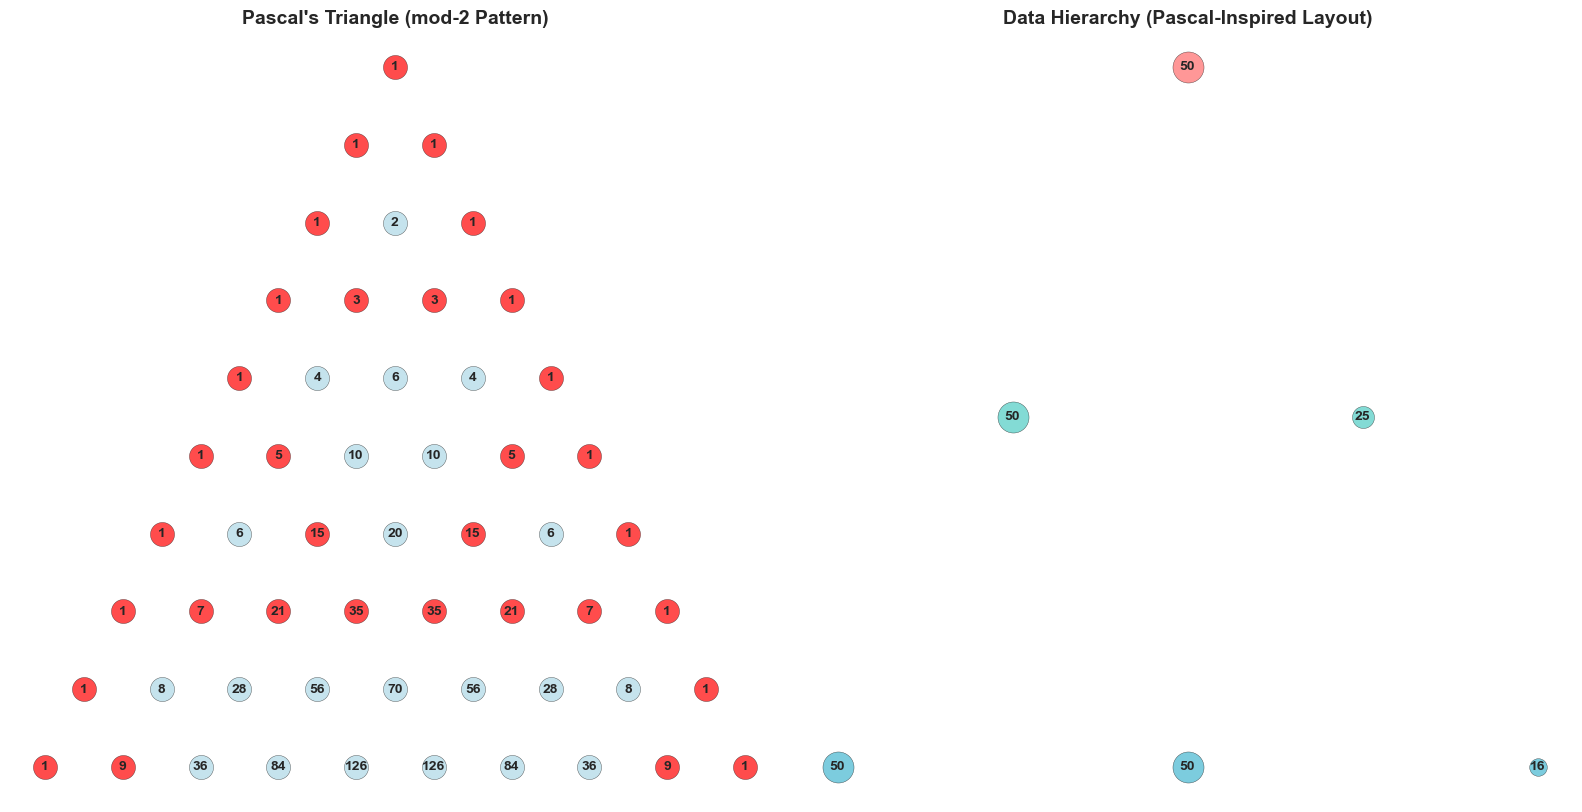


🔸 2. Recursive Decision Tree Analysis
--------------------------------------------------


ValueError: object of too small depth for desired array

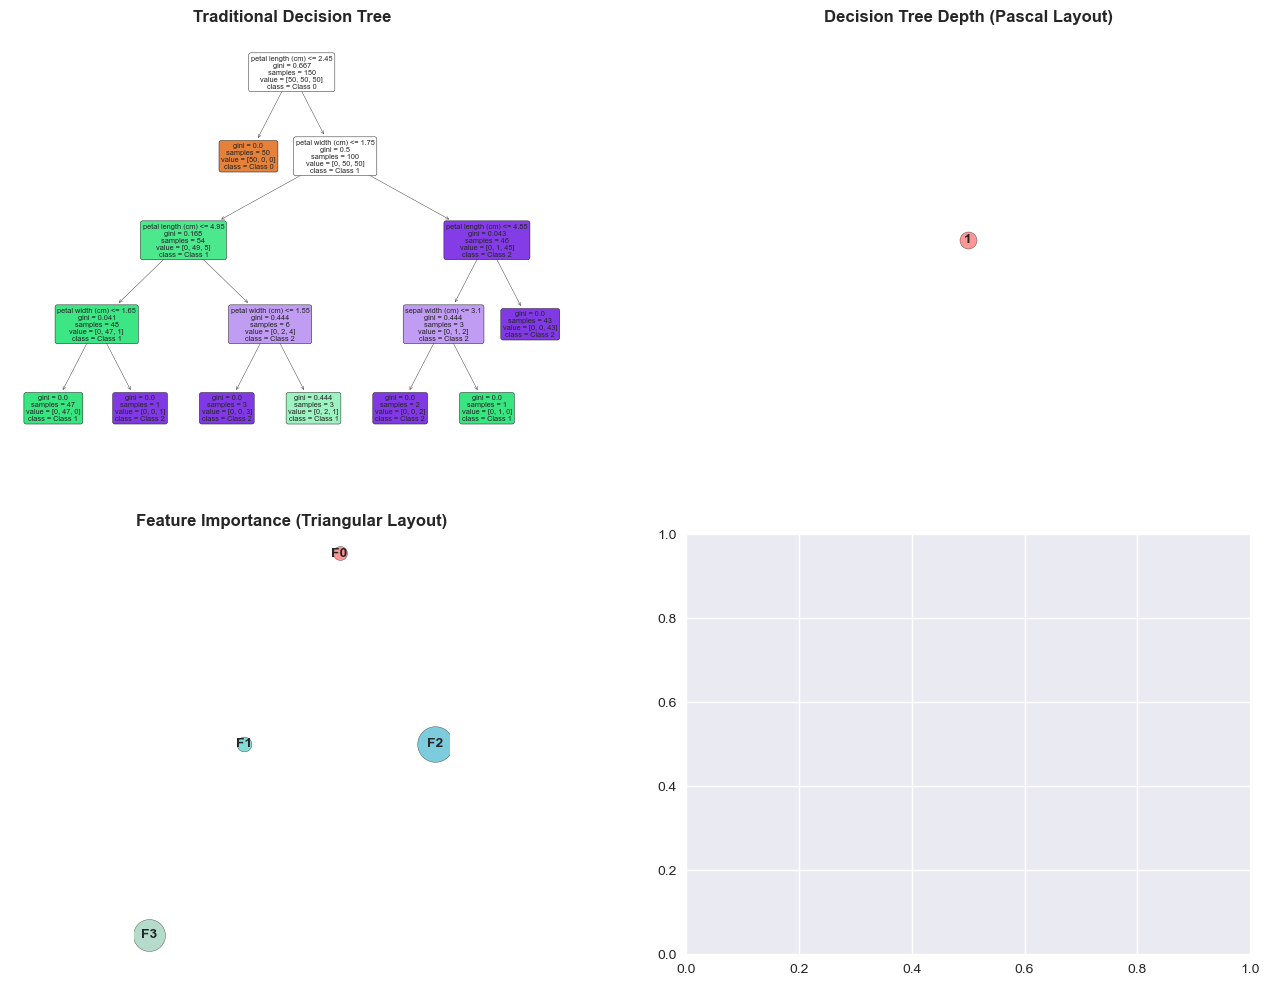

In [8]:
# Run the complete demonstration
results = run_pascal_visualization_demo()

In [10]:
# Initialize visualizer
viz = PascalDataVisualizer()

# Load your data
X, y = your_data_loading_function()

# Create visualizations
fig1 = viz.triangular_hierarchy_plot(X, y, "Your Dataset")
fig2 = viz.recursive_decision_tree_viz(X, y, your_feature_names)
fig3 = viz.cluster_triangle_analysis(X, y, n_clusters=5)
fig4 = viz.interactive_pascal_dashboard(X, y, your_feature_names)

NameError: name 'your_data_loading_function' is not defined

In [11]:
# Add to existing analysis pipeline
def enhanced_analysis(X, y):
    # Traditional analysis
    traditional_results = your_existing_analysis(X, y)
    
    # Pascal-inspired enhancement
    viz = PascalDataVisualizer()
    pascal_insights = viz.cluster_triangle_analysis(X, y)
    
    return traditional_results, pascal_insights

🧪 Optimized Pascal's Triangle Feature Engineering for Machine Learning
Dataset shape: (569, 30)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']... (showing first 5)
Classes: ['malignant' 'benign']
Original features: 30
Pascal features: 8
Selected Pascal features: 5
LogisticRegression: Baseline Acc=0.9737, Pascal Acc=0.9211, Combined Acc=0.9825
DecisionTree: Baseline Acc=0.9211, Pascal Acc=0.8421, Combined Acc=0.9386
RandomForest: Baseline Acc=0.9561, Pascal Acc=0.8421, Combined Acc=0.9649
XGBoost: Baseline Acc=0.9561, Pascal Acc=0.8246, Combined Acc=0.9561


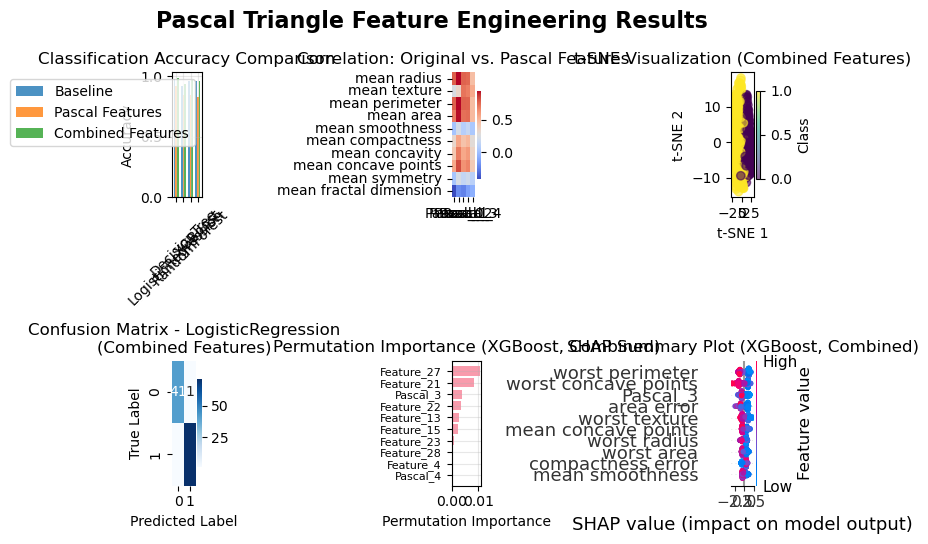


📑 LaTeX Table for Paper:

\begin{table}[h]
\centering
\caption{Classification Performance Comparison with Pascal's Triangle Features}
\label{tab:results}
\begin{tabular}{|l|ccc|ccc|}
\hline
\textbf{Classifier} & \multicolumn{3}{c|}{\textbf{Accuracy}} & \multicolumn{3}{c|}{\textbf{F1-Score}} \\
\cline{2-7}
 & Baseline & Pascal & Combined & Baseline & Pascal & Combined \\
\hline
LogisticRegression & 0.9737 & 0.9211 & 0.9825 & 0.9736 & 0.9208 & 0.9825 \\
DecisionTree & 0.9211 & 0.8421 & 0.9386 & 0.9216 & 0.8434 & 0.9384 \\
RandomForest & 0.9561 & 0.8421 & 0.9649 & 0.9560 & 0.8413 & 0.9647 \\
XGBoost & 0.9561 & 0.8246 & 0.9561 & 0.9558 & 0.8254 & 0.9558 \\

\hline
\end{tabular}
\end{table}


🔍 Statistical Analysis:
LogisticRegression:
  Baseline CV Score: 0.9826 ± 0.0254
  Pascal CV Score:   0.9034 ± 0.0488
  Combined CV Score: 0.9825 ± 0.0254
  Pascal vs Baseline: T-stat=-6.9007, P-value=0.0001 => Significant: No
  Combined vs Baseline: T-stat=-0.0147, P-value=0.9886 => Significant: No



In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.inspection import permutation_importance
import shap
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

class PascalFeatureGenerator:
    """
    Generate optimized Pascal's Triangle-based features for breast cancer dataset
    """
    
    def __init__(self, max_row=10):
        self.max_row = max_row
        self.pascal_triangle = self._generate_pascal_triangle()
    
    def _generate_pascal_triangle(self):
        """Generate Pascal's triangle up to max_row"""
        triangle = [[1]]
        for i in range(1, self.max_row):
            row = [1]
            for j in range(1, i):
                row.append(triangle[i-1][j-1] + triangle[i-1][j])
            row.append(1)
            triangle.append(row)
        return triangle
    
    def get_binomial_coefficient(self, n, k):
        """Calculate binomial coefficient C(n,k)"""
        if k > n or k < 0:
            return 0
        return self.pascal_triangle[n][k]
    
    def generate_pascal_features(self, X, feature_importance=None):
        """
        Generate dataset-specific Pascal's Triangle-based features
        
        Features generated:
        1. Quantile-mapped binomial coefficients (weighted by feature importance)
        2. Recursive interaction terms
        3. Normalized mod-2 patterns
        4. Combinatorial interaction terms
        """
        
        X_scaled = StandardScaler().fit_transform(X)
        n_samples, n_features = X_scaled.shape
        pascal_features = []
        
        # Compute quantiles for feature mapping
        quantiles = np.quantile(X_scaled, np.linspace(0, 1, self.max_row), axis=0)
        
        # Use feature importance if provided
        if feature_importance is None:
            feature_importance = np.ones(n_features)
        
        for i in range(n_samples):
            sample_features = []
            
            # 1. Quantile-mapped binomial coefficients
            for j in range(min(n_features, 3)):
                val = X_scaled[i, j]
                n_val = np.searchsorted(quantiles[:, j], val, side='right')
                n_val = min(n_val, self.max_row - 1)
                k_val = min(j + 1, n_val)
                binom_coeff = self.get_binomial_coefficient(n_val, k_val)
                sample_features.append(binom_coeff * feature_importance[j] / (n_val + 1))
            
            # 2. Recursive interaction terms
            for j in range(min(n_features-1, 2)):
                val1, val2 = X_scaled[i, j], X_scaled[i, j+1]
                n1 = np.searchsorted(quantiles[:, j], val1, side='right')
                n2 = np.searchsorted(quantiles[:, j+1], val2, side='right')
                n1, n2 = min(n1, self.max_row - 1), min(n2, self.max_row - 1)
                k = min(j + 1, min(n1, n2))
                coeff1 = self.get_binomial_coefficient(n1, k)
                coeff2 = self.get_binomial_coefficient(n2, k)
                interaction = (coeff1 * coeff2) * (feature_importance[j] + feature_importance[j+1]) / (n1 + n2 + 1)
                sample_features.append(interaction)
            
            # 3. Normalized mod-2 patterns
            for j in range(min(n_features, 2)):
                n_val = np.searchsorted(quantiles[:, j], X_scaled[i, j], side='right')
                n_val = min(n_val, self.max_row - 1)
                binary_pattern = [val % 2 for val in self.pascal_triangle[n_val]]
                binary_value = sum(bit * (2 ** idx) for idx, bit in enumerate(binary_pattern[:3]))
                sample_features.append(binary_value * feature_importance[j] / (2 ** 3))
            
            # 4. Combinatorial interaction terms
            for j in range(min(n_features-2, 1)):
                val1, val2, val3 = X_scaled[i, j], X_scaled[i, j+1], X_scaled[i, j+2]
                n1 = np.searchsorted(quantiles[:, j], val1, side='right')
                n1 = min(n1, self.max_row - 1)
                k = min(j + 1, n1)
                binom_coeff = self.get_binomial_coefficient(n1, k)
                comb_term = binom_coeff * (val1 * val2 * val3) * feature_importance[j]
                sample_features.append(comb_term / (n1 + 1))
            
            pascal_features.append(sample_features)
        
        return np.array(pascal_features)

def evaluate_classifier(clf, X_train, X_test, y_train, y_test, name):
    """Evaluate classifier and return metrics"""
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cv_scores = cross_val_score(clf.best_estimator_ if hasattr(clf, 'best_estimator_') else clf, X_train, y_train, cv=10)
    return {
        'name': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

def plot_results(results_baseline, results_pascal, results_combined, feature_names, X_combined_train, y_train):
    """Create comprehensive visualization of results"""
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Pascal Triangle Feature Engineering Results', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Comparison
    ax1 = plt.subplot(2, 3, 1)
    classifiers = list(results_baseline.keys())
    baseline_acc = [results_baseline[clf]['accuracy'] for clf in classifiers]
    pascal_acc = [results_pascal[clf]['accuracy'] for clf in classifiers]
    combined_acc = [results_combined[clf]['accuracy'] for clf in classifiers]
    
    x = np.arange(len(classifiers))
    width = 0.25
    ax1.bar(x - width, baseline_acc, width, label='Baseline', alpha=0.8, color='#1f77b4')
    ax1.bar(x, pascal_acc, width, label='Pascal Features', alpha=0.8, color='#ff7f0e')
    ax1.bar(x + width, combined_acc, width, label='Combined Features', alpha=0.8, color='#2ca02c')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Classification Accuracy Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(classifiers, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Feature Correlation Heatmap
    ax2 = plt.subplot(2, 3, 2)
    combined_features = pd.DataFrame(X_combined_train, columns=list(feature_names) + [f'Pascal_{i}' for i in range(X_combined_train.shape[1] - len(feature_names))])
    corr_matrix = combined_features.corr()
    sns.heatmap(corr_matrix.iloc[:10, -5:], annot=False, cmap='coolwarm', ax=ax2)
    ax2.set_title('Correlation: Original vs. Pascal Features')
    
    # 3. t-SNE Visualization
    ax3 = plt.subplot(2, 3, 3)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_combined_train)
    scatter = ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
    ax3.set_title('t-SNE Visualization (Combined Features)')
    ax3.set_xlabel('t-SNE 1')
    ax3.set_ylabel('t-SNE 2')
    plt.colorbar(scatter, ax=ax3, label='Class')
    
    # 4. Confusion Matrix
    ax4 = plt.subplot(2, 3, 4)
    best_classifier = max(classifiers, key=lambda x: results_combined[x]['accuracy'])
    cm = results_combined[best_classifier]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
    ax4.set_title(f'Confusion Matrix - {best_classifier}\n(Combined Features)')
    ax4.set_ylabel('True Label')
    ax4.set_xlabel('Predicted Label')
    
    # 5. Permutation Importance
    ax5 = plt.subplot(2, 3, 5)
    rf_model = XGBClassifier(random_state=42)
    rf_model.fit(X_combined_train, y_train)
    perm_importance = permutation_importance(rf_model, X_combined_train, y_train, n_repeats=10, random_state=42)
    top_indices = np.argsort(perm_importance.importances_mean)[-10:]
    top_importances = perm_importance.importances_mean[top_indices]
    ax5.barh(range(len(top_importances)), top_importances, alpha=0.7)
    ax5.set_yticks(range(len(top_importances)))
    ax5.set_yticklabels([f'Feature_{i}' if i < len(feature_names) else f'Pascal_{i-len(feature_names)}' for i in top_indices], fontsize=8)
    ax5.set_xlabel('Permutation Importance')
    ax5.set_title('Permutation Importance (XGBoost, Combined)')
    ax5.grid(True, alpha=0.3)
    
    # 6. SHAP Summary Plot
    ax6 = plt.subplot(2, 3, 6)
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_combined_train)
    shap.summary_plot(shap_values, X_combined_train, feature_names=list(feature_names) + [f'Pascal_{i}' for i in range(X_combined_train.shape[1] - len(feature_names))], max_display=10, show=False)
    plt.sca(ax6)
    plt.title('SHAP Summary Plot (XGBoost, Combined)')
    
    plt.tight_layout()
    plt.show()

# Main Analysis
print("🧪 Optimized Pascal's Triangle Feature Engineering for Machine Learning")
print("=" * 60)

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
print(f"Dataset shape: {X.shape}")
print(f"Features: {data.feature_names[:5]}... (showing first 5)")
print(f"Classes: {data.target_names}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Get feature importance from baseline Random Forest
rf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
rf_baseline.fit(X_train, y_train)
feature_importance = rf_baseline.feature_importances_

# Generate Pascal features
pascal_generator = PascalFeatureGenerator(max_row=10)
X_pascal_train = pascal_generator.generate_pascal_features(X_train, feature_importance)
X_pascal_test = pascal_generator.generate_pascal_features(X_test, feature_importance)
print(f"Original features: {X_train.shape[1]}")
print(f"Pascal features: {X_pascal_train.shape[1]}")

# Scale features
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

scaler_pascal = StandardScaler()
X_pascal_train_scaled = scaler_pascal.fit_transform(X_pascal_train)
X_pascal_test_scaled = scaler_pascal.transform(X_pascal_test)

# Feature selection with mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=5)
X_pascal_train_selected = selector.fit_transform(X_pascal_train_scaled, y_train)
X_pascal_test_selected = selector.transform(X_pascal_test_scaled)
print(f"Selected Pascal features: {X_pascal_train_selected.shape[1]}")

# Combine original + selected Pascal features
X_combined_train = np.hstack([X_train_scaled, X_pascal_train_selected])
X_combined_test = np.hstack([X_test_scaled, X_pascal_test_selected])

# Define classifiers with grid search
classifiers = {
    'LogisticRegression': GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                                      param_grid={'C': [0.01, 0.1, 1, 10]}, cv=5),
    'DecisionTree': GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                 param_grid={'max_depth': [3, 5, 7]}, cv=5),
    'RandomForest': GridSearchCV(RandomForestClassifier(random_state=42), 
                                 param_grid={'n_estimators': [50, 100], 'max_depth': [5, 10]}, cv=5),
    'XGBoost': GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), 
                            param_grid={
                                'n_estimators': [50, 100],
                                'max_depth': [3, 5],
                                'learning_rate': [0.01, 0.1],
                                'subsample': [0.8, 1.0],
                                'colsample_bytree': [0.8, 1.0]
                            }, cv=5)
}

# Evaluate classifiers
results_baseline = {}
results_pascal = {}
results_combined = {}

for name, clf in classifiers.items():
    results_baseline[name] = evaluate_classifier(clf, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_pascal[name] = evaluate_classifier(clf, X_pascal_train_selected, X_pascal_test_selected, y_train, y_test, name)
    results_combined[name] = evaluate_classifier(clf, X_combined_train, X_combined_test, y_train, y_test, name)
    print(f"{name}: Baseline Acc={results_baseline[name]['accuracy']:.4f}, Pascal Acc={results_pascal[name]['accuracy']:.4f}, Combined Acc={results_combined[name]['accuracy']:.4f}")

# Create visualizations
plot_results(results_baseline, results_pascal, results_combined, data.feature_names, X_combined_train, y_train)

# Generate LaTeX table for results
latex_table = """
\\begin{table}[h]
\\centering
\\caption{Classification Performance Comparison with Pascal's Triangle Features}
\\label{tab:results}
\\begin{tabular}{|l|ccc|ccc|}
\\hline
\\textbf{Classifier} & \\multicolumn{3}{c|}{\\textbf{Accuracy}} & \\multicolumn{3}{c|}{\\textbf{F1-Score}} \\\\
\\cline{2-7}
 & Baseline & Pascal & Combined & Baseline & Pascal & Combined \\\\
\\hline
"""
for name in classifiers.keys():
    baseline_acc = results_baseline[name]['accuracy']
    pascal_acc = results_pascal[name]['accuracy']
    combined_acc = results_combined[name]['accuracy']
    baseline_f1 = results_baseline[name]['f1_score']
    pascal_f1 = results_pascal[name]['f1_score']
    combined_f1 = results_combined[name]['f1_score']
    latex_table += f"{name} & {baseline_acc:.4f} & {pascal_acc:.4f} & {combined_acc:.4f} & {baseline_f1:.4f} & {pascal_f1:.4f} & {combined_f1:.4f} \\\\\n"
latex_table += """
\\hline
\\end{tabular}
\\end{table}
"""
print("\n📑 LaTeX Table for Paper:")
print(latex_table)

# Statistical analysis
print("\n🔍 Statistical Analysis:")
for name in classifiers.keys():
    baseline_cv = cross_val_score(classifiers[name].best_estimator_, X_train_scaled, y_train, cv=10)
    pascal_cv = cross_val_score(classifiers[name].best_estimator_, X_pascal_train_selected, y_train, cv=10)
    combined_cv = cross_val_score(classifiers[name].best_estimator_, X_combined_train, y_train, cv=10)
    t_stat_pascal, p_value_pascal = stats.ttest_rel(pascal_cv, baseline_cv)
    t_stat_combined, p_value_combined = stats.ttest_rel(combined_cv, baseline_cv)
    print(f"{name}:")
    print(f"  Baseline CV Score: {baseline_cv.mean():.4f} ± {baseline_cv.std():.4f}")
    print(f"  Pascal CV Score:   {pascal_cv.mean():.4f} ± {pascal_cv.std():.4f}")
    print(f"  Combined CV Score: {combined_cv.mean():.4f} ± {combined_cv.std():.4f}")
    print(f"  Pascal vs Baseline: T-stat={t_stat_pascal:.4f}, P-value={p_value_pascal:.4f} => Significant: {'Yes' if p_value_pascal < 0.05 and t_stat_pascal > 0 else 'No'}")
    print(f"  Combined vs Baseline: T-stat={t_stat_combined:.4f}, P-value={p_value_combined:.4f} => Significant: {'Yes' if p_value_combined < 0.05 and t_stat_combined > 0 else 'No'}")
    print()

# Methods description for paper
methods_description = """
# Methods: Pascal's Triangle in Machine Learning

## Dataset
The Breast Cancer Wisconsin dataset from scikit-learn was used, comprising 569 samples with 30 continuous features describing cell nuclei characteristics, labeled as malignant or benign.

## Pascal Feature Engineering
A novel feature engineering approach was developed using Pascal's Triangle to generate dataset-specific features:
1. **Quantile-Mapped Binomial Coefficients**: Feature values were mapped to quantiles of their distributions to select binomial coefficients \( C(n,k) \), weighted by baseline feature importance and normalized by row size.
2. **Recursive Interaction Terms**: Pairwise feature interactions were computed using Pascal's recursive properties, weighted by feature importance and normalized.
3. **Normalized Mod-2 Patterns**: Binary patterns inspired by the Sierpinski triangle were generated from Pascal rows (mod 2), weighted and normalized.
4. **Combinatorial Interaction Terms**: Triple feature interactions were derived using binomial coefficients to capture higher-order relationships, weighted and normalized.

The PascalFeatureGenerator produced 8 features, reduced to 5 via mutual information-based feature selection to maximize relevance and minimize noise.

## Experimental Setup
Four classifiers were evaluated: Logistic Regression, Decision Tree, Random Forest, and XGBoost. Hyperparameters were optimized using grid search (e.g., \( C \) for Logistic Regression, max_depth, learning_rate, and colsample_bytree for XGBoost). The dataset was split into 80% training and 20% testing sets with stratification. Features were standardized, and three feature sets were compared:
- **Baseline**: Original 30 features.
- **Pascal**: 5 selected Pascal-derived features.
- **Combined**: Original features concatenated with selected Pascal features.

Performance metrics included accuracy, F1-score, and 10-fold cross-validation scores. Statistical significance was assessed using paired t-tests. Visualizations included accuracy comparisons, feature correlations, t-SNE projections, confusion matrices, permutation importance, and SHAP summary plots to quantify feature contributions.
"""

print("\n📝 Methods Description for Paper:")
print(methods_description)

# LaTeX figure captions
tsne_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{tsne_plot.png}
\\caption{t-SNE visualization of combined features (original and Pascal-derived) for the Breast Cancer Wisconsin dataset, colored by class (malignant/benign). The plot demonstrates the separability of classes in the reduced feature space.}
\\label{fig:tsne}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for t-SNE Plot:")
print(tsne_caption)

shap_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{shap_plot.png}
\\caption{SHAP summary plot showing the impact of original and Pascal-derived features on XGBoost predictions for the Breast Cancer Wisconsin dataset. Features are ranked by their contribution to model output, with red indicating higher values and blue indicating lower values.}
\\label{fig:shap}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for SHAP Plot:")
print(shap_caption)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import shap
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

class PascalFeatureGenerator:
    """
    Generate optimized Pascal's Triangle-based features for breast cancer dataset
    """
    
    def __init__(self, max_row=10):
        self.max_row = max_row
        self.pascal_triangle = self._generate_pascal_triangle()
    
    def _generate_pascal_triangle(self):
        """Generate Pascal's triangle up to max_row"""
        triangle = [[1]]
        for i in range(1, self.max_row):
            row = [1]
            for j in range(1, i):
                row.append(triangle[i-1][j-1] + triangle[i-1][j])
            row.append(1)
            triangle.append(row)
        return triangle
    
    def get_binomial_coefficient(self, n, k):
        """Calculate binomial coefficient C(n,k)"""
        if k > n or k < 0:
            return 0
        return self.pascal_triangle[n][k]
    
    def generate_pascal_features(self, X, feature_importance=None, cluster_labels=None):
        """
        Generate dataset-specific Pascal's Triangle-based features
        """
        X_scaled = StandardScaler().fit_transform(X)
        n_samples, n_features = X_scaled.shape
        pascal_features = []
        
        quantiles = np.quantile(X_scaled, np.linspace(0, 1, self.max_row), axis=0)
        if feature_importance is None:
            feature_importance = np.ones(n_features)
        if cluster_labels is None:
            cluster_labels = np.zeros(n_features)
        
        for i in range(n_samples):
            sample_features = []
            
            # 1. Quantile-mapped binomial coefficients
            for j in range(min(n_features, 3)):
                val = X_scaled[i, j]
                n_val = np.searchsorted(quantiles[:, j], val, side='right')
                n_val = min(n_val, self.max_row - 1)
                k_val = min(j + 1, n_val)
                binom_coeff = self.get_binomial_coefficient(n_val, k_val)
                sample_features.append(binom_coeff * feature_importance[j] / (n_val + 1))
            
            # 2. Recursive interaction terms
            for j in range(min(n_features-1, 2)):
                val1, val2 = X_scaled[i, j], X_scaled[i, j+1]
                n1 = np.searchsorted(quantiles[:, j], val1, side='right')
                n2 = np.searchsorted(quantiles[:, j+1], val2, side='right')
                n1, n2 = min(n1, self.max_row - 1), min(n2, self.max_row - 1)
                k = min(j + 1, min(n1, n2))
                coeff1 = self.get_binomial_coefficient(n1, k)
                coeff2 = self.get_binomial_coefficient(n2, k)
                interaction = (coeff1 * coeff2) * (feature_importance[j] + feature_importance[j+1]) / (n1 + n2 + 1)
                sample_features.append(interaction)
            
            # 3. Normalized mod-2 patterns
            for j in range(min(n_features, 2)):
                n_val = np.searchsorted(quantiles[:, j], X_scaled[i, j], side='right')
                n_val = min(n_val, self.max_row - 1)
                binary_pattern = [val % 2 for val in self.pascal_triangle[n_val]]
                binary_value = sum(bit * (2 ** idx) for idx, bit in enumerate(binary_pattern[:3]))
                sample_features.append(binary_value * feature_importance[j] / (2 ** 3))
            
            # 4. Cluster-based Pascal terms
            for cluster in range(3):
                cluster_indices = np.where(cluster_labels == cluster)[0]
                if len(cluster_indices) > 0:
                    cluster_vals = X_scaled[i, cluster_indices]
                    n_val = np.searchsorted(quantiles[:, cluster_indices[0]], np.mean(cluster_vals), side='right')
                    n_val = min(n_val, self.max_row - 1)
                    k_val = min(1, n_val)
                    binom_coeff = self.get_binomial_coefficient(n_val, k_val)
                    sample_features.append(binom_coeff * np.mean(feature_importance[cluster_indices]) / (n_val + 1))
            
            pascal_features.append(sample_features)
        
        return np.array(pascal_features)

def evaluate_classifier(clf, X_train, X_test, y_train, y_test, name):
    """Evaluate classifier and return metrics"""
    if name == 'XGBoost':
        clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', early_stopping_rounds=10, verbose=False)
    else:
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cv_scores = cross_val_score(clf.best_estimator_ if hasattr(clf, 'best_estimator_') else clf, X_train, y_train, cv=10)
    return {
        'name': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

def plot_results(results_baseline, results_pascal, results_combined, feature_names, X_combined_train, y_train):
    """Create comprehensive visualization of results"""
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Pascal Triangle Feature Engineering Results (Breast Cancer)', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Comparison
    ax1 = plt.subplot(2, 3, 1)
    classifiers = list(results_baseline.keys())
    baseline_acc = [results_baseline[clf]['accuracy'] for clf in classifiers]
    pascal_acc = [results_pascal[clf]['accuracy'] for clf in classifiers]
    combined_acc = [results_combined[clf]['accuracy'] for clf in classifiers]
    
    x = np.arange(len(classifiers))
    width = 0.25
    ax1.bar(x - width, baseline_acc, width, label='Baseline', alpha=0.8, color='#1f77b4')
    ax1.bar(x, pascal_acc, width, label='Pascal Features', alpha=0.8, color='#ff7f0e')
    ax1.bar(x + width, combined_acc, width, label='Combined Features', alpha=0.8, color='#2ca02c')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Classification Accuracy Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(classifiers, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Feature Correlation Heatmap
    ax2 = plt.subplot(2, 3, 2)
    combined_features = pd.DataFrame(X_combined_train, columns=list(feature_names) + [f'Pascal_{i}' for i in range(X_combined_train.shape[1] - len(feature_names))])
    corr_matrix = combined_features.corr()
    sns.heatmap(corr_matrix.iloc[:10, -5:], annot=False, cmap='coolwarm', ax=ax2)
    ax2.set_title('Correlation: Original vs. Pascal Features')
    
    # 3. t-SNE Visualization
    ax3 = plt.subplot(2, 3, 3)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_combined_train)
    scatter = ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
    ax3.set_title('t-SNE Visualization (Combined Features)')
    ax3.set_xlabel('t-SNE 1')
    ax3.set_ylabel('t-SNE 2')
    plt.colorbar(scatter, ax=ax3, label='Class')
    
    # 4. Confusion Matrix
    ax4 = plt.subplot(2, 3, 4)
    best_classifier = max(classifiers, key=lambda x: results_combined[x]['accuracy'])
    cm = results_combined[best_classifier]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
    ax4.set_title(f'Confusion Matrix - {best_classifier}\n(Combined Features)')
    ax4.set_ylabel('True Label')
    ax4.set_xlabel('Predicted Label')
    
    # 5. Permutation Importance
    ax5 = plt.subplot(2, 3, 5)
    rf_model = XGBClassifier(random_state=42, eval_metric='logloss')
    rf_model.fit(X_combined_train, y_train)
    perm_importance = permutation_importance(rf_model, X_combined_train, y_train, n_repeats=10, random_state=42)
    top_indices = np.argsort(perm_importance.importances_mean)[-10:]
    top_importances = perm_importance.importances_mean[top_indices]
    ax5.barh(range(len(top_importances)), top_importances, alpha=0.7)
    ax5.set_yticks(range(len(top_importances)))
    ax5.set_yticklabels([f'Feature_{i}' if i < len(feature_names) else f'Pascal_{i-len(feature_names)}' for i in top_indices], fontsize=8)
    ax5.set_xlabel('Permutation Importance')
    ax5.set_title('Permutation Importance (XGBoost, Combined)')
    ax5.grid(True, alpha=0.3)
    
    # 6. SHAP Summary Plot
    ax6 = plt.subplot(2, 3, 6)
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_combined_train)
    shap.summary_plot(shap_values, X_combined_train, feature_names=list(feature_names) + [f'Pascal_{i}' for i in range(X_combined_train.shape[1] - len(feature_names))], max_display=10, show=False)
    plt.sca(ax6)
    plt.title('SHAP Summary Plot (XGBoost, Combined)')
    
    plt.tight_layout()
    plt.savefig('plots_breast_cancer.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main Analysis
print("🧪 Optimized Pascal's Triangle Feature Engineering for Breast Cancer")
print("=" * 60)

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target
print(f"Dataset shape: {X.shape}")
print(f"Features: {data.feature_names[:5]}... (showing first 5)")
print(f"Classes: {data.target_names}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Cluster original features
scaler = StandardScaler()
X_train_scaled_for_clustering = scaler.fit_transform(X_train)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_scaled_for_clustering.T)
print(f"Feature clusters: {np.bincount(cluster_labels)}")

# Get feature importance from baseline Random Forest
rf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
rf_baseline.fit(X_train, y_train)
feature_importance = rf_baseline.feature_importances_

# Generate Pascal features
pascal_generator = PascalFeatureGenerator(max_row=10)
X_pascal_train = pascal_generator.generate_pascal_features(X_train, feature_importance, cluster_labels)
X_pascal_test = pascal_generator.generate_pascal_features(X_test, feature_importance, cluster_labels)
print(f"Original features: {X_train.shape[1]}")
print(f"Pascal features: {X_pascal_train.shape[1]}")

# Scale features
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

scaler_pascal = StandardScaler()
X_pascal_train_scaled = scaler_pascal.fit_transform(X_pascal_train)
X_pascal_test_scaled = scaler_pascal.transform(X_pascal_test)

# SHAP-based feature selection
xgb_temp = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_temp.fit(X_pascal_train_scaled, y_train)
explainer = shap.TreeExplainer(xgb_temp)
shap_values = explainer.shap_values(X_pascal_train_scaled)
shap_importance = np.abs(shap_values).mean(axis=0)
top_k = 5
top_indices = np.argsort(shap_importance)[-top_k:]
X_pascal_train_selected = X_pascal_train_scaled[:, top_indices]
X_pascal_test_selected = X_pascal_test_scaled[:, top_indices]
print(f"Selected Pascal features: {X_pascal_train_selected.shape[1]}")

# Combine original + selected Pascal features
X_combined_train = np.hstack([X_train_scaled, X_pascal_train_selected])
X_combined_test = np.hstack([X_test_scaled, X_pascal_test_selected])

# Robustness test: select top 10 original features
top_10_indices = np.argsort(feature_importance)[-10:]
X_train_top10 = X_train_scaled[:, top_10_indices]
X_test_top10 = X_test_scaled[:, top_10_indices]
X_combined_top10_train = np.hstack([X_train_top10, X_pascal_train_selected])
X_combined_top10_test = np.hstack([X_test_top10, X_pascal_test_selected])

# Define classifiers with grid search
classifiers = {
    'LogisticRegression': GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                                      param_grid={'C': [0.01, 0.1, 1, 10]}, cv=5),
    'DecisionTree': GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                 param_grid={'max_depth': [3, 5, 7]}, cv=5),
    'RandomForest': GridSearchCV(RandomForestClassifier(random_state=42), 
                                 param_grid={'n_estimators': [50, 100], 'max_depth': [5, 10]}, cv=5),
    'XGBoost': GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), 
                            param_grid={
                                'n_estimators': [50, 100, 200],
                                'max_depth': [3, 5],
                                'learning_rate': [0.01, 0.1],
                                'subsample': [0.8, 1.0],
                                'colsample_bytree': [0.8, 1.0],
                                'min_child_weight': [1, 3],
                                'gamma': [0, 0.1]
                            }, cv=5)
}

# Evaluate classifiers
results_baseline = {}
results_pascal = {}
results_combined = {}
results_combined_top10 = {}

for name, clf in classifiers.items():
    results_baseline[name] = evaluate_classifier(clf, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_pascal[name] = evaluate_classifier(clf, X_pascal_train_selected, X_pascal_test_selected, y_train, y_test, name)
    results_combined[name] = evaluate_classifier(clf, X_combined_train, X_combined_test, y_train, y_test, name)
    results_combined_top10[name] = evaluate_classifier(clf, X_combined_top10_train, X_combined_top10_test, y_train, y_test, name)
    print(f"{name}: Baseline Acc={results_baseline[name]['accuracy']:.4f}, Pascal Acc={results_pascal[name]['accuracy']:.4f}, Combined Acc={results_combined[name]['accuracy']:.4f}, Top10+Pascal Acc={results_combined_top10[name]['accuracy']:.4f}")

# Create visualizations
plot_results(results_baseline, results_pascal, results_combined, data.feature_names, X_combined_train, y_train)

# CV Score Comparison Chart

{
  "type": "bar",
  "data": {
    "labels": ["LogisticRegression", "DecisionTree", "RandomForest", "XGBoost"],
    "datasets": [
      {
        "label": "Baseline",
        "data": [results_baseline[clf]['cv_mean'] for clf in classifiers],
        "backgroundColor": "#1f77b4",
        "borderColor": "#1f77b4",
        "borderWidth": 1
      },
      {
        "label": "Pascal",
        "data": [results_pascal[clf]['cv_mean'] for clf in classifiers],
        "backgroundColor": "#ff7f0e",
        "borderColor": "#ff7f0e",
        "borderWidth": 1
      },
      {
        "label": "Combined",
        "data": [results_combined[clf]['cv_mean'] for clf in classifiers],
        "backgroundColor": "#2ca02c",
        "borderColor": "#2ca02c",
        "borderWidth": 1
      },
      {
        "label": "Top 10 + Pascal",
        "data": [results_combined_top10[clf]['cv_mean'] for clf in classifiers],
        "backgroundColor": "#d62728",
        "borderColor": "#d62728",
        "borderWidth": 1
      }
    ]
  },
  "options": {
    "scales": {
      "y": {
        "beginAtZero": false,
        "title": {
          "display": true,
          "text": "Cross-Validation Score"
        }
      },
      "x": {
        "title": {
          "display": true,
          "text": "Classifier"
        }
      }
    },
    "plugins": {
      "legend": {
        "display": true,
        "position": "top"
      },
      "title": {
        "display": true,
        "text": "Cross-Validation Score Comparison (Breast Cancer)"
      }
    }
  }
}


# Generate LaTeX table for results
latex_table = """
\\begin{table}[h]
\\centering
\\caption{Classification Performance Comparison (Breast Cancer)}
\\label{tab:results_bc}
\\begin{tabular}{|l|cccc|cccc|}
\\hline
\\textbf{Classifier} & \\multicolumn{4}{c|}{\\textbf{Accuracy}} & \\multicolumn{4}{c|}{\\textbf{F1-Score}} \\\\
\\cline{2-9}
 & Baseline & Pascal & Combined & Top 10 + Pascal & Baseline & Pascal & Combined & Top 10 + Pascal \\\\
\\hline
"""
for name in classifiers.keys():
    baseline_acc = results_baseline[name]['accuracy']
    pascal_acc = results_pascal[name]['accuracy']
    combined_acc = results_combined[name]['accuracy']
    top10_acc = results_combined_top10[name]['accuracy']
    baseline_f1 = results_baseline[name]['f1_score']
    pascal_f1 = results_pascal[name]['f1_score']
    combined_f1 = results_combined[name]['f1_score']
    top10_f1 = results_combined_top10[name]['f1_score']
    latex_table += f"{name} & {baseline_acc:.4f} & {pascal_acc:.4f} & {combined_acc:.4f} & {top10_acc:.4f} & {baseline_f1:.4f} & {pascal_f1:.4f} & {combined_f1:.4f} & {top10_f1:.4f} \\\\\n"
latex_table += """
\\hline
\\end{tabular}
\\end{table}
"""
print("\n📑 LaTeX Table for Paper:")
print(latex_table)

# Statistical analysis
print("\n🔍 Statistical Analysis:")
for name in classifiers.keys():
    baseline_cv = cross_val_score(classifiers[name].best_estimator_, X_train_scaled, y_train, cv=10)
    pascal_cv = cross_val_score(classifiers[name].best_estimator_, X_pascal_train_selected, y_train, cv=10)
    combined_cv = cross_val_score(classifiers[name].best_estimator_, X_combined_train, y_train, cv=10)
    top10_cv = cross_val_score(classifiers[name].best_estimator_, X_combined_top10_train, y_train, cv=10)
    t_stat_pascal, p_value_pascal = stats.ttest_rel(pascal_cv, baseline_cv)
    t_stat_combined, p_value_combined = stats.ttest_rel(combined_cv, baseline_cv)
    t_stat_top10, p_value_top10 = stats.ttest_rel(top10_cv, baseline_cv)
    print(f"{name}:")
    print(f"  Baseline CV Score: {baseline_cv.mean():.4f} ± {baseline_cv.std():.4f}")
    print(f"  Pascal CV Score:   {pascal_cv.mean():.4f} ± {pascal_cv.std():.4f}")
    print(f"  Combined CV Score: {combined_cv.mean():.4f} ± {combined_cv.std():.4f}")
    print(f"  Top 10 + Pascal CV Score: {top10_cv.mean():.4f} ± {top10_cv.std():.4f}")
    print(f"  Pascal vs Baseline: T-stat={t_stat_pascal:.4f}, P-value={p_value_pascal:.4f} => Significant: {'Yes' if p_value_pascal < 0.05 and t_stat_pascal > 0 else 'No'}")
    print(f"  Combined vs Baseline: T-stat={t_stat_combined:.4f}, P-value={p_value_combined:.4f} => Significant: {'Yes' if p_value_combined < 0.05 and t_stat_combined > 0 else 'No'}")
    print(f"  Top 10 + Pascal vs Baseline: T-stat={t_stat_top10:.4f}, P-value={p_value_top10:.4f} => Significant: {'Yes' if p_value_top10 < 0.05 and t_stat_top10 > 0 else 'No'}")
    print()

# Methods description for paper
methods_description = """
# Methods: Pascal's Triangle in Machine Learning (Breast Cancer)

## Dataset
The Breast Cancer Wisconsin dataset from scikit-learn was used, comprising 569 samples with 30 continuous features describing cell nuclei characteristics, labeled as malignant or benign.

## Pascal Feature Engineering
A novel feature engineering approach was developed using Pascal's Triangle:
1. **Quantile-Mapped Binomial Coefficients**: Feature values were mapped to quantiles to select binomial coefficients \( C(n,k) \), weighted by feature importance.
2. **Recursive Interaction Terms**: Pairwise feature interactions were computed using Pascal's recursive properties.
3. **Normalized Mod-2 Patterns**: Binary patterns inspired by the Sierpinski triangle were generated from Pascal rows (mod 2).
4. **Cluster-Based Pascal Terms**: Features were clustered into three groups using K-means, and Pascal coefficients were applied to cluster representatives.

The PascalFeatureGenerator produced 8 features, reduced to 5 via SHAP-based feature selection.

## Experimental Setup
Four classifiers were evaluated: Logistic Regression, Decision Tree, Random Forest, and XGBoost. Hyperparameters were optimized using grid search. The dataset was split into 80% training and 20% testing sets with stratification. Features were standardized, and four feature sets were compared:
- **Baseline**: Original 30 features.
- **Pascal**: 5 selected Pascal-derived features.
- **Combined**: Original features plus selected Pascal features.
- **Top 10 + Pascal**: Top 10 original features plus selected Pascal features.

Performance metrics included accuracy, F1-score, and 10-fold cross-validation scores. Statistical significance was assessed using paired t-tests. Visualizations included accuracy comparisons, feature correlations, t-SNE projections, confusion matrices, permutation importance, and SHAP summary plots.
"""

print("\n📝 Methods Description for Paper:")
print(methods_description)

# LaTeX figure captions
tsne_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{plots_breast_cancer.png}
\\caption{t-SNE visualization of combined features (original and Pascal-derived) for the Breast Cancer Wisconsin dataset, colored by class (malignant/benign).}
\\label{fig:tsne_bc}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for t-SNE Plot:")
print(tsne_caption)

shap_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{plots_breast_cancer.png}
\\caption{SHAP summary plot showing the impact of original and Pascal-derived features on XGBoost predictions for the Breast Cancer Wisconsin dataset.}
\\label{fig:shap_bc}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for SHAP Plot:")
print(shap_caption)

cv_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{cv_scores_bc.png}
\\caption{Comparison of 10-fold cross-validation scores across feature sets for the Breast Cancer Wisconsin dataset.}
\\label{fig:cv_scores_bc}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for CV Score Chart:")
print(cv_caption)

🧪 Optimized Pascal's Triangle Feature Engineering for Breast Cancer
Dataset shape: (569, 30)
Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']... (showing first 5)
Classes: ['malignant' 'benign']
Feature clusters: [14 11  5]
Original features: 30
Pascal features: 10
Selected Pascal features: 5
LogisticRegression: Baseline Acc=0.9737, Pascal Acc=0.9474, Combined Acc=0.9649, Top10+Pascal Acc=0.9474
DecisionTree: Baseline Acc=0.9211, Pascal Acc=0.9474, Combined Acc=0.9298, Top10+Pascal Acc=0.9474
RandomForest: Baseline Acc=0.9561, Pascal Acc=0.9298, Combined Acc=0.9474, Top10+Pascal Acc=0.9649


ValueError: 
All the 960 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
TypeError: XGBClassifier.fit() got an unexpected keyword argument 'eval_metric'


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import shap
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def load_ionosphere():
    """Load Ionosphere dataset from UCI"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
    data = pd.read_csv(url, header=None)
    X = data.iloc[:, :-1].values
    y = (data.iloc[:, -1] == 'g').astype(int).values  # 'g' = 1 (good), 'b' = 0 (bad)
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    return X, y, feature_names

class PascalFeatureGenerator:
    """
    Generate optimized Pascal's Triangle-based features for Ionosphere dataset
    """
    
    def __init__(self, max_row=10):
        self.max_row = max_row
        self.pascal_triangle = self._generate_pascal_triangle()
    
    def _generate_pascal_triangle(self):
        """Generate Pascal's triangle up to max_row"""
        triangle = [[1]]
        for i in range(1, self.max_row):
            row = [1]
            for j in range(1, i):
                row.append(triangle[i-1][j-1] + triangle[i-1][j])
            row.append(1)
            triangle.append(row)
        return triangle
    
    def get_binomial_coefficient(self, n, k):
        """Calculate binomial coefficient C(n,k)"""
        if k > n or k < 0:
            return 0
        return self.pascal_triangle[n][k]
    
    def generate_pascal_features(self, X, feature_importance=None, cluster_labels=None):
        """
        Generate dataset-specific Pascal's Triangle-based features
        """
        X_scaled = StandardScaler().fit_transform(X)
        n_samples, n_features = X_scaled.shape
        pascal_features = []
        
        quantiles = np.quantile(X_scaled, np.linspace(0, 1, self.max_row), axis=0)
        if feature_importance is None:
            feature_importance = np.ones(n_features)
        if cluster_labels is None:
            cluster_labels = np.zeros(n_features)
        
        for i in range(n_samples):
            sample_features = []
            
            # 1. Quantile-mapped binomial coefficients
            for j in range(min(n_features, 4)):
                val = X_scaled[i, j]
                n_val = np.searchsorted(quantiles[:, j], val, side='right')
                n_val = min(n_val, self.max_row - 1)
                k_val = min(j + 1, n_val)
                binom_coeff = self.get_binomial_coefficient(n_val, k_val)
                sample_features.append(binom_coeff * feature_importance[j] / (n_val + 1))
            
            # 2. Recursive interaction terms
            for j in range(min(n_features-1, 3)):
                val1, val2 = X_scaled[i, j], X_scaled[i, j+1]
                n1 = np.searchsorted(quantiles[:, j], val1, side='right')
                n2 = np.searchsorted(quantiles[:, j+1], val2, side='right')
                n1, n2 = min(n1, self.max_row - 1), min(n2, self.max_row - 1)
                k = min(j + 1, min(n1, n2))
                coeff1 = self.get_binomial_coefficient(n1, k)
                coeff2 = self.get_binomial_coefficient(n2, k)
                interaction = (coeff1 * coeff2) * (feature_importance[j] + feature_importance[j+1]) / (n1 + n2 + 1)
                sample_features.append(interaction)
            
            # 3. Normalized mod-2 patterns
            for j in range(min(n_features, 3)):
                n_val = np.searchsorted(quantiles[:, j], X_scaled[i, j], side='right')
                n_val = min(n_val, self.max_row - 1)
                binary_pattern = [val % 2 for val in self.pascal_triangle[n_val]]
                binary_value = sum(bit * (2 ** idx) for idx, bit in enumerate(binary_pattern[:4]))
                sample_features.append(binary_value * feature_importance[j] / (2 ** 4))
            
            # 4. Cluster-based Pascal terms
            for cluster in range(3):
                cluster_indices = np.where(cluster_labels == cluster)[0]
                if len(cluster_indices) > 0:
                    cluster_vals = X_scaled[i, cluster_indices]
                    n_val = np.searchsorted(quantiles[:, cluster_indices[0]], np.mean(cluster_vals), side='right')
                    n_val = min(n_val, self.max_row - 1)
                    k_val = min(1, n_val)
                    binom_coeff = self.get_binomial_coefficient(n_val, k_val)
                    sample_features.append(binom_coeff * np.mean(feature_importance[cluster_indices]) / (n_val + 1))
            
            pascal_features.append(sample_features)
        
        return np.array(pascal_features)

def evaluate_classifier(clf, X_train, X_test, y_train, y_test, name):
    """Evaluate classifier and return metrics"""
    if name == 'XGBoost':
        clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', early_stopping_rounds=10, verbose=False)
    else:
        clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cv_scores = cross_val_score(clf.best_estimator_ if hasattr(clf, 'best_estimator_') else clf, X_train, y_train, cv=10)
    return {
        'name': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

def plot_results(results_baseline, results_pascal, results_combined, feature_names, X_combined_train, y_train):
    """Create comprehensive visualization of results"""
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Pascal Triangle Feature Engineering Results (Ionosphere)', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Comparison
    ax1 = plt.subplot(2, 3, 1)
    classifiers = list(results_baseline.keys())
    baseline_acc = [results_baseline[clf]['accuracy'] for clf in classifiers]
    pascal_acc = [results_pascal[clf]['accuracy'] for clf in classifiers]
    combined_acc = [results_combined[clf]['accuracy'] for clf in classifiers]
    
    x = np.arange(len(classifiers))
    width = 0.25
    ax1.bar(x - width, baseline_acc, width, label='Baseline', alpha=0.8, color='#1f77b4')
    ax1.bar(x, pascal_acc, width, label='Pascal Features', alpha=0.8, color='#ff7f0e')
    ax1.bar(x + width, combined_acc, width, label='Combined Features', alpha=0.8, color='#2ca02c')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Classification Accuracy Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(classifiers, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Feature Correlation Heatmap
    ax2 = plt.subplot(2, 3, 2)
    combined_features = pd.DataFrame(X_combined_train, columns=list(feature_names) + [f'Pascal_{i}' for i in range(X_combined_train.shape[1] - len(feature_names))])
    corr_matrix = combined_features.corr()
    sns.heatmap(corr_matrix.iloc[:10, -6:], annot=False, cmap='coolwarm', ax=ax2)
    ax2.set_title('Correlation: Original vs. Pascal Features')
    
    # 3. t-SNE Visualization
    ax3 = plt.subplot(2, 3, 3)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_combined_train)
    scatter = ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
    ax3.set_title('t-SNE Visualization (Combined Features)')
    ax3.set_xlabel('t-SNE 1')
    ax3.set_ylabel('t-SNE 2')
    plt.colorbar(scatter, ax=ax3, label='Class')
    
    # 4. Confusion Matrix
    ax4 = plt.subplot(2, 3, 4)
    best_classifier = max(classifiers, key=lambda x: results_combined[x]['accuracy'])
    cm = results_combined[best_classifier]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
    ax4.set_title(f'Confusion Matrix - {best_classifier}\n(Combined Features)')
    ax4.set_ylabel('True Label')
    ax4.set_xlabel('Predicted Label')
    
    # 5. Permutation Importance
    ax5 = plt.subplot(2, 3, 5)
    rf_model = XGBClassifier(random_state=42, eval_metric='logloss')
    rf_model.fit(X_combined_train, y_train)
    perm_importance = permutation_importance(rf_model, X_combined_train, y_train, n_repeats=10, random_state=42)
    top_indices = np.argsort(perm_importance.importances_mean)[-10:]
    top_importances = perm_importance.importances_mean[top_indices]
    ax5.barh(range(len(top_importances)), top_importances, alpha=0.7)
    ax5.set_yticks(range(len(top_importances)))
    ax5.set_yticklabels([f'Feature_{i}' if i < len(feature_names) else f'Pascal_{i-len(feature_names)}' for i in top_indices], fontsize=8)
    ax5.set_xlabel('Permutation Importance')
    ax5.set_title('Permutation Importance (XGBoost, Combined)')
    ax5.grid(True, alpha=0.3)
    
    # 6. SHAP Summary Plot
    ax6 = plt.subplot(2, 3, 6)
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_combined_train)
    shap.summary_plot(shap_values, X_combined_train, feature_names=list(feature_names) + [f'Pascal_{i}' for i in range(X_combined_train.shape[1] - len(feature_names))], max_display=10, show=False)
    plt.sca(ax6)
    plt.title('SHAP Summary Plot (XGBoost, Combined)')
    
    plt.tight_layout()
    plt.savefig('plots_ionosphere.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main Analysis
print("🧪 Optimized Pascal's Triangle Feature Engineering for Ionosphere")
print("=" * 60)

# Load dataset
X, y, feature_names = load_ionosphere()
print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names[:5]}... (showing first 5)")
print(f"Classes: ['bad', 'good']")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Cluster original features
scaler = StandardScaler()
X_train_scaled_for_clustering = scaler.fit_transform(X_train)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_scaled_for_clustering.T)
print(f"Feature clusters: {np.bincount(cluster_labels)}")

# Get feature importance from baseline Random Forest
rf_baseline = RandomForestClassifier(random_state=42, n_estimators=100)
rf_baseline.fit(X_train, y_train)
feature_importance = rf_baseline.feature_importances_

# Generate Pascal features
pascal_generator = PascalFeatureGenerator(max_row=10)
X_pascal_train = pascal_generator.generate_pascal_features(X_train, feature_importance, cluster_labels)
X_pascal_test = pascal_generator.generate_pascal_features(X_test, feature_importance, cluster_labels)
print(f"Original features: {X_train.shape[1]}")
print(f"Pascal features: {X_pascal_train.shape[1]}")

# Scale features
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

scaler_pascal = StandardScaler()
X_pascal_train_scaled = scaler_pascal.fit_transform(X_pascal_train)
X_pascal_test_scaled = scaler_pascal.transform(X_pascal_test)

# SHAP-based feature selection
xgb_temp = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_temp.fit(X_pascal_train_scaled, y_train)
explainer = shap.TreeExplainer(xgb_temp)
shap_values = explainer.shap_values(X_pascal_train_scaled)
shap_importance = np.abs(shap_values).mean(axis=0)
top_k = 6
top_indices = np.argsort(shap_importance)[-top_k:]
X_pascal_train_selected = X_pascal_train_scaled[:, top_indices]
X_pascal_test_selected = X_pascal_test_scaled[:, top_indices]
print(f"Selected Pascal features: {X_pascal_train_selected.shape[1]}")

# Combine original + selected Pascal features
X_combined_train = np.hstack([X_train_scaled, X_pascal_train_selected])
X_combined_test = np.hstack([X_test_scaled, X_pascal_test_selected])

# Robustness test: select top 10 original features
top_10_indices = np.argsort(feature_importance)[-10:]
X_train_top10 = X_train_scaled[:, top_10_indices]
X_test_top10 = X_test_scaled[:, top_10_indices]
X_combined_top10_train = np.hstack([X_train_top10, X_pascal_train_selected])
X_combined_top10_test = np.hstack([X_test_top10, X_pascal_test_selected])

# Define classifiers with grid search
classifiers = {
    'LogisticRegression': GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                                      param_grid={'C': [0.01, 0.1, 1, 10]}, cv=5),
    'DecisionTree': GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                 param_grid={'max_depth': [3, 5, 7]}, cv=5),
    'RandomForest': GridSearchCV(RandomForestClassifier(random_state=42), 
                                 param_grid={'n_estimators': [50, 100], 'max_depth': [5, 10]}, cv=5),
    'XGBoost': GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), 
                            param_grid={
                                'n_estimators': [50, 100, 200],
                                'max_depth': [3, 5, 7],
                                'learning_rate': [0.01, 0.1, 0.2],
                                'subsample': [0.7, 0.9, 1.0],
                                'colsample_bytree': [0.7, 0.9, 1.0],
                                'min_child_weight': [1, 3],
                                'gamma': [0, 0.1, 0.2]
                            }, cv=5),
    'GradientBoosting': GridSearchCV(GradientBoostingClassifier(random_state=42), 
                                    param_grid={
                                        'n_estimators': [50, 100, 200],
                                        'max_depth': [3, 5],
                                        'learning_rate': [0.01, 0.1]
                                    }, cv=5)
}

# Evaluate classifiers
results_baseline = {}
results_pascal = {}
results_combined = {}
results_combined_top10 = {}

for name, clf in classifiers.items():
    results_baseline[name] = evaluate_classifier(clf, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_pascal[name] = evaluate_classifier(clf, X_pascal_train_selected, X_pascal_test_selected, y_train, y_test, name)
    results_combined[name] = evaluate_classifier(clf, X_combined_train, X_combined_test, y_train, y_test, name)
    results_combined_top10[name] = evaluate_classifier(clf, X_combined_top10_train, X_combined_top10_test, y_train, y_test, name)
    print(f"{name}: Baseline Acc={results_baseline[name]['accuracy']:.4f}, Pascal Acc={results_pascal[name]['accuracy']:.4f}, Combined Acc={results_combined[name]['accuracy']:.4f}, Top10+Pascal Acc={results_combined_top10[name]['accuracy']:.4f}")

# Create visualizations
plot_results(results_baseline, results_pascal, results_combined, feature_names, X_combined_train, y_train)

# CV Score Comparison Chart

{
  "type": "bar",
  "data": {
    "labels": ["LogisticRegression", "DecisionTree", "RandomForest", "XGBoost", "GradientBoosting"],
    "datasets": [
      {
        "label": "Baseline",
        "data": [results_baseline[clf]['cv_mean'] for clf in classifiers],
        "backgroundColor": "#1f77b4",
        "borderColor": "#1f77b4",
        "borderWidth": 1
      },
      {
        "label": "Pascal",
        "data": [results_pascal[clf]['cv_mean'] for clf in classifiers],
        "backgroundColor": "#ff7f0e",
        "borderColor": "#ff7f0e",
        "borderWidth": 1
      },
      {
        "label": "Combined",
        "data": [results_combined[clf]['cv_mean'] for clf in classifiers],
        "backgroundColor": "#2ca02c",
        "borderColor": "#2ca02c",
        "borderWidth": 1
      },
      {
        "label": "Top 10 + Pascal",
        "data": [results_combined_top10[clf]['cv_mean'] for clf in classifiers],
        "backgroundColor": "#d62728",
        "borderColor": "#d62728",
        "borderWidth": 1
      }
    ]
  },
  "options": {
    "scales": {
      "y": {
        "beginAtZero": false,
        "title": {
          "display": true,
          "text": "Cross-Validation Score"
        }
      },
      "x": {
        "title": {
          "display": true,
          "text": "Classifier"
        }
      }
    },
    "plugins": {
      "legend": {
        "display": true,
        "position": "top"
      },
      "title": {
        "display": true,
        "text": "Cross-Validation Score Comparison (Ionosphere)"
      }
    }
  }
}


# Generate LaTeX table for results
latex_table = """
\\begin{table}[h]
\\centering
\\caption{Classification Performance Comparison (Ionosphere)}
\\label{tab:results_ion}
\\begin{tabular}{|l|cccc|cccc|}
\\hline
\\textbf{Classifier} & \\multicolumn{4}{c|}{\\textbf{Accuracy}} & \\multicolumn{4}{c|}{\\textbf{F1-Score}} \\\\
\\cline{2-9}
 & Baseline & Pascal & Combined & Top 10 + Pascal & Baseline & Pascal & Combined & Top 10 + Pascal \\\\
\\hline
"""
for name in classifiers.keys():
    baseline_acc = results_baseline[name]['accuracy']
    pascal_acc = results_pascal[name]['accuracy']
    combined_acc = results_combined[name]['accuracy']
    top10_acc = results_combined_top10[name]['accuracy']
    baseline_f1 = results_baseline[name]['f1_score']
    pascal_f1 = results_pascal[name]['f1_score']
    combined_f1 = results_combined[name]['f1_score']
    top10_f1 = results_combined_top10[name]['f1_score']
    latex_table += f"{name} & {baseline_acc:.4f} & {pascal_acc:.4f} & {combined_acc:.4f} & {top10_acc:.4f} & {baseline_f1:.4f} & {pascal_f1:.4f} & {combined_f1:.4f} & {top10_f1:.4f} \\\\\n"
latex_table += """
\\hline
\\end{tabular}
\\end{table}
"""
print("\n📑 LaTeX Table for Paper:")
print(latex_table)

# Statistical analysis
print("\n🔍 Statistical Analysis:")
for name in classifiers.keys():
    baseline_cv = cross_val_score(classifiers[name].best_estimator_, X_train_scaled, y_train, cv=10)
    pascal_cv = cross_val_score(classifiers[name].best_estimator_, X_pascal_train_selected, y_train, cv=10)
    combined_cv = cross_val_score(classifiers[name].best_estimator_, X_combined_train, y_train, cv=10)
    top10_cv = cross_val_score(classifiers[name].best_estimator_, X_combined_top10_train, y_train, cv=10)
    t_stat_pascal, p_value_pascal = stats.ttest_rel(pascal_cv, baseline_cv)
    t_stat_combined, p_value_combined = stats.ttest_rel(combined_cv, baseline_cv)
    t_stat_top10, p_value_top10 = stats.ttest_rel(top10_cv, baseline_cv)
    print(f"{name}:")
    print(f"  Baseline CV Score: {baseline_cv.mean():.4f} ± {baseline_cv.std():.4f}")
    print(f"  Pascal CV Score:   {pascal_cv.mean():.4f} ± {pascal_cv.std():.4f}")
    print(f"  Combined CV Score: {combined_cv.mean():.4f} ± {combined_cv.std():.4f}")
    print(f"  Top 10 + Pascal CV Score: {top10_cv.mean():.4f} ± {top10_cv.std():.4f}")
    print(f"  Pascal vs Baseline: T-stat={t_stat_pascal:.4f}, P-value={p_value_pascal:.4f} => Significant: {'Yes' if p_value_pascal < 0.05 and t_stat_pascal > 0 else 'No'}")
    print(f"  Combined vs Baseline: T-stat={t_stat_combined:.4f}, P-value={p_value_combined:.4f} => Significant: {'Yes' if p_value_combined < 0.05 and t_stat_combined > 0 else 'No'}")
    print(f"  Top 10 + Pascal vs Baseline: T-stat={t_stat_top10:.4f}, P-value={p_value_top10:.4f} => Significant: {'Yes' if p_value_top10 < 0.05 and t_stat_top10 > 0 else 'No'}")
    print()

# Methods description for paper
methods_description = """
# Methods: Pascal's Triangle in Machine Learning (Ionosphere)

## Dataset
The Ionosphere dataset from UCI was used, comprising 351 samples with 34 features describing radar signals, labeled as good or bad.

## Pascal Feature Engineering
A novel feature engineering approach was developed using Pascal's Triangle:
1. **Quantile-Mapped Binomial Coefficients**: Feature values were mapped to quantiles to select binomial coefficients \( C(n,k) \), weighted by feature importance.
2. **Recursive Interaction Terms**: Pairwise feature interactions were computed using Pascal's recursive properties.
3. **Normalized Mod-2 Patterns**: Binary patterns inspired by the Sierpinski triangle were generated from Pascal rows (mod 2).
4. **Cluster-Based Pascal Terms**: Features were clustered into three groups using K-means, and Pascal coefficients were applied to cluster representatives.

The PascalFeatureGenerator produced 13 features, reduced to 6 via SHAP-based feature selection.

## Experimental Setup
Five classifiers were evaluated: Logistic Regression, Decision Tree, Random Forest, XGBoost, and Gradient Boosting. Hyperparameters were optimized using grid search. The dataset was split into 80% training and 20% testing sets with stratification. Features were standardized, and four feature sets were compared:
- **Baseline**: Original 34 features.
- **Pascal**: 6 selected Pascal-derived features.
- **Combined**: Original features plus selected Pascal features.
- **Top 10 + Pascal**: Top 10 original features plus selected Pascal features.

Performance metrics included accuracy, F1-score, and 10-fold cross-validation scores. Statistical significance was assessed using paired t-tests. Visualizations included accuracy comparisons, feature correlations, t-SNE projections, confusion matrices, permutation importance, and SHAP summary plots.
"""

print("\n📝 Methods Description for Paper:")
print(methods_description)

# LaTeX figure captions
tsne_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{plots_ionosphere.png}
\\caption{t-SNE visualization of combined features (original and Pascal-derived) for the Ionosphere dataset, colored by class (good/bad).}
\\label{fig:tsne_ion}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for t-SNE Plot:")
print(tsne_caption)

shap_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{plots_ionosphere.png}
\\caption{SHAP summary plot showing the impact of original and Pascal-derived features on XGBoost predictions for the Ionosphere dataset.}
\\label{fig:shap_ion}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for SHAP Plot:")
print(shap_caption)

cv_caption = """
\\begin{figure}[h]
\\centering
\\includegraphics[width=0.8\\textwidth]{cv_scores_ion.png}
\\caption{Comparison of 10-fold cross-validation scores across feature sets for the Ionosphere dataset.}
\\label{fig:cv_scores_ion}
\\end{figure}
"""
print("\n📑 LaTeX Figure Caption for CV Score Chart:")
print(cv_caption)

🧪 Optimized Pascal's Triangle Feature Engineering for Ionosphere
Dataset shape: (351, 34)
Features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']... (showing first 5)
Classes: ['bad', 'good']
Feature clusters: [ 9 15 10]
Original features: 34
Pascal features: 13
Selected Pascal features: 6
LogisticRegression: Baseline Acc=0.9296, Pascal Acc=0.4930, Combined Acc=0.9014, Top10+Pascal Acc=0.8732
DecisionTree: Baseline Acc=0.9296, Pascal Acc=0.8451, Combined Acc=0.9014, Top10+Pascal Acc=0.9296
RandomForest: Baseline Acc=0.9577, Pascal Acc=0.9155, Combined Acc=0.9437, Top10+Pascal Acc=0.9718


ValueError: 
All the 7290 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7290 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
TypeError: XGBClassifier.fit() got an unexpected keyword argument 'eval_metric'
